In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Brandeis99_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/Brandeis99_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 1000:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Brandeis', ref_nodes) 
            np.save('results/info_ref_nodes_Brandeis', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 2 Feature value  2007  gap  [0.90911795]  volume:  63073.0  size: 680 conductance:  0.4394114755917746
Reached
Number of feature 2 Feature value  2008  gap  [0.91702467]  volume:  63716.0  size: 722 conductance:  0.33595957059451315
Reached
Number of feature 2 Feature value  2009  gap  [0.88030531]  volume:  32534.0  size: 677 conductance:  0.14403393373086618


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [7]:
ref_nodes = np.load('results/ref_nodes_Brandeis.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Brandeis.npy') 

## Visualize the ground truth clusters

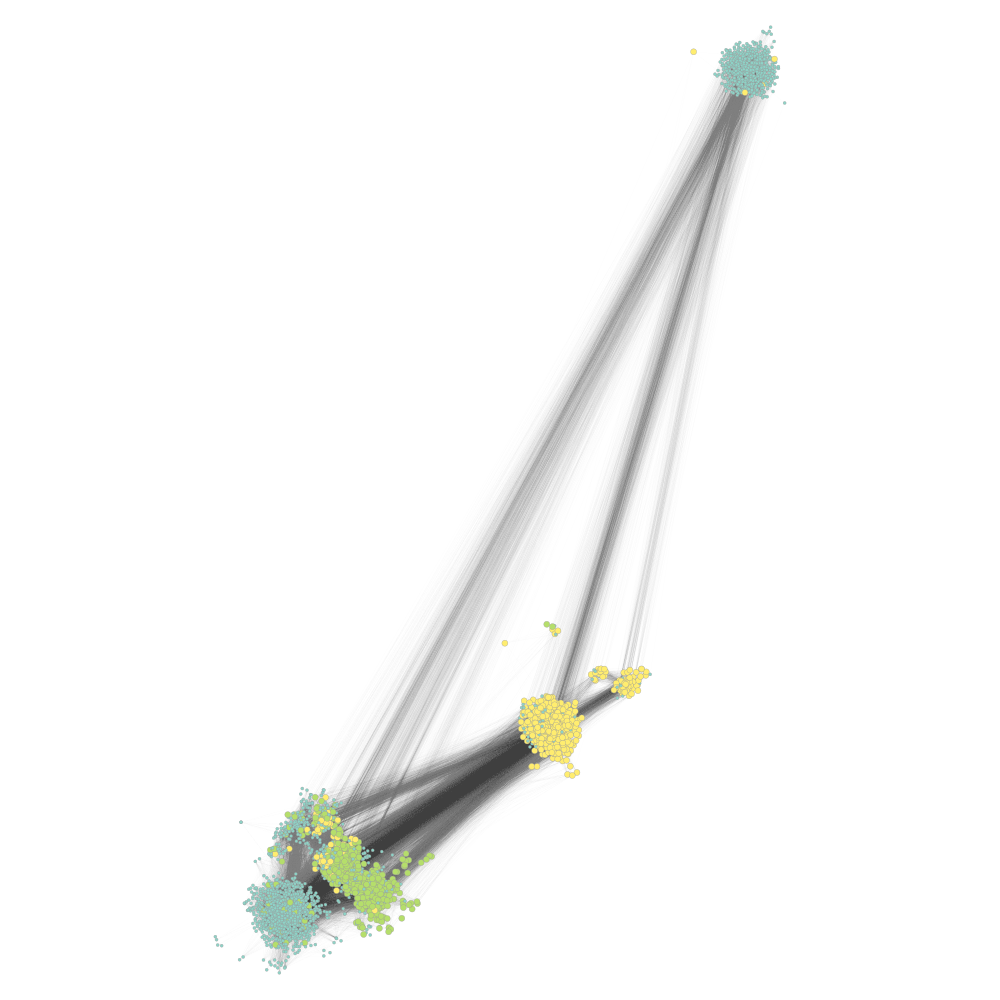

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14b4e9ef0, at 0x148347eb8>

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [9]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_Brandeis', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_Brandeis', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_Brandeis', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_Brandeis', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_Brandeis', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_Brandeis', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_Brandeis', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_Brandeis', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_Brandeis', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_Brandeis', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_Brandeis', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_Brandeis', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_Brandeis', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_Brandeis', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_Brandeis', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_Brandeis', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_Brandeis', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_Brandeis', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_Brandeis', cuts_acl_ALL) 
    
    np.save('results/nodes_Brandeis', nodes)

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.23365636055991387 f1score:  0.6422875586536115 precision:  0.5611293437437058 recall:  0.7508918237597704
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.20615922538999462 f1score:  0.4789536906429279 precision:  0.3492832010235831 recall:  0.7617522553231969
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.27017371812832724 f1score:  0.4659418881129339 precision:  0.33980660171586446 recall:  0.7409985255180506
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.25978234912837306 f1score:  0.5296680291097597 precision:  0.38627523682813875 recall:  0.8423731232064433
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.2383213002340685 f1score:  0.6755733067066066 precision:  0.5822471085000918 recall:  0.80452808650294

outer: 0 number of node:  1869  completed:  0.12058823529411765  degree:  86.0
conductance:  0.20255324959038776 f1score:  0.5542149452565662 precision:  0.40422112160815715 recall:  0.8812011478762704
outer: 0 number of node:  905  completed:  0.12352941176470589  degree:  8.0
conductance:  0.15022456735450235 f1score:  0.41478458409277014 precision:  0.2619451754294508 recall:  0.9958302284654289
outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.21963539811546806 f1score:  0.5588795633592504 precision:  0.4704046806435885 recall:  0.6883452507412047
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.1518083095749111 f1score:  0.530514606943157 precision:  0.3868590325980303 recall:  0.8438793144451667
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.1762629893471015 f1score:  0.6035392488530212 precision:  0.5181185777939438 recall:  0.7226864109840978
o

outer: 0 number of node:  3814  completed:  0.24411764705882352  degree:  136.0
conductance:  0.3274438032586469 f1score:  0.6237660631354116 precision:  0.5600837791460583 recall:  0.7037876745992738
outer: 0 number of node:  1007  completed:  0.24705882352941178  degree:  96.0
conductance:  0.24684436801375753 f1score:  0.47914785341881405 precision:  0.3495799420509311 recall:  0.7613241799185071
outer: 0 number of node:  1365  completed:  0.25  degree:  44.0
conductance:  0.20339668418924384 f1score:  0.4504435363301107 precision:  0.3284685326375312 recall:  0.716518954227641
outer: 0 number of node:  3277  completed:  0.2529411764705882  degree:  85.0
conductance:  0.2618289910823571 f1score:  0.5730147633342929 precision:  0.504678313151191 recall:  0.6627558543275253
outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.33503955328059565 f1score:  0.49904250862739624 precision:  0.3640206328073277 recall:  0.7932871434686791
outer: 0 num

outer: 0 number of node:  2703  completed:  0.36764705882352944  degree:  138.0
conductance:  0.32808784496236776 f1score:  0.591005816427862 precision:  0.5148900607373228 recall:  0.6935297195313367
outer: 0 number of node:  2274  completed:  0.37058823529411766  degree:  85.0
conductance:  0.33239770504439387 f1score:  0.6051272734895226 precision:  0.5409774623956823 recall:  0.6865378212547366
outer: 0 number of node:  3039  completed:  0.3735294117647059  degree:  96.0
conductance:  0.2059628840888348 f1score:  0.6339868833135738 precision:  0.5583236770954036 recall:  0.7333724414567248
outer: 0 number of node:  2257  completed:  0.3764705882352941  degree:  85.0
conductance:  0.25968425668761874 f1score:  0.4058529617105886 precision:  0.254589414879876 recall:  1.0
outer: 0 number of node:  2568  completed:  0.37941176470588234  degree:  52.0
conductance:  0.23880597014925373 f1score:  0.4775620142802448 precision:  0.4143046944198406 recall:  0.5636167615302903
outer: 0 numbe

outer: 0 number of node:  1940  completed:  0.49117647058823527  degree:  28.0
conductance:  0.34841089134119463 f1score:  0.5343025399324411 precision:  0.3895714213061515 recall:  0.8501418990693324
outer: 0 number of node:  1452  completed:  0.49411764705882355  degree:  45.0
conductance:  0.35813419217878717 f1score:  0.5576556908016069 precision:  0.4066841634617482 recall:  0.8868929652941829
outer: 0 number of node:  72  completed:  0.4970588235294118  degree:  16.0
conductance:  0.325055071283688 f1score:  0.5290646090658053 precision:  0.385833412093145 recall:  0.8414218445293549
outer: 0 number of node:  2620  completed:  0.5  degree:  267.0
conductance:  0.16234768614313397 f1score:  0.4921895570918577 precision:  0.40095177285152744 recall:  0.637182312558464
outer: 0 number of node:  889  completed:  0.5029411764705882  degree:  41.0
conductance:  0.2825577373861584 f1score:  0.49769249937702464 precision:  0.3629313039243478 recall:  0.7916382604283925
outer: 0 number of

outer: 0 number of node:  3004  completed:  0.6147058823529412  degree:  38.0
conductance:  0.20580791261489276 f1score:  0.4717101922779752 precision:  0.4401296275952983 recall:  0.5081730693006516
outer: 0 number of node:  3652  completed:  0.6176470588235294  degree:  159.0
conductance:  0.16163208677555654 f1score:  0.623300187782777 precision:  0.5172190209263655 recall:  0.7841231588793938
outer: 0 number of node:  3572  completed:  0.6205882352941177  degree:  177.0
conductance:  0.28570181945111045 f1score:  0.49730917365801985 precision:  0.42319763171366886 recall:  0.6028887162494253
outer: 0 number of node:  2725  completed:  0.6235294117647059  degree:  73.0
conductance:  0.38723398067429127 f1score:  0.43716233727397785 precision:  0.31879538565540705 recall:  0.6953371490178047
outer: 0 number of node:  693  completed:  0.6264705882352941  degree:  54.0
conductance:  0.26985895873236987 f1score:  0.6394196550780182 precision:  0.5625248353342084 recall:  0.7406655779810

outer: 0 number of node:  1618  completed:  0.7382352941176471  degree:  94.0
conductance:  0.2940625835784969 f1score:  0.4073649961559547 precision:  0.25607677123607236 recall:  0.995497280928448
outer: 0 number of node:  1572  completed:  0.7411764705882353  degree:  70.0
conductance:  0.19256565117287863 f1score:  0.5196488481881583 precision:  0.37898839475291585 recall:  0.8263440774975029
outer: 0 number of node:  3562  completed:  0.7441176470588236  degree:  129.0
conductance:  0.2048554373561877 f1score:  0.6545423362093986 precision:  0.5604532155485015 recall:  0.7865964834398237
outer: 0 number of node:  297  completed:  0.7470588235294118  degree:  67.0
conductance:  0.23102631945411503 f1score:  0.5416885984400528 precision:  0.476133823635446 recall:  0.62817687441536
outer: 0 number of node:  1887  completed:  0.75  degree:  113.0
conductance:  0.22141658274588788 f1score:  0.6042965341965177 precision:  0.5025394054741801 recall:  0.7577251755901891
outer: 0 number o

outer: 0 number of node:  1779  completed:  0.861764705882353  degree:  6.0
conductance:  0.16367100666878373 f1score:  0.5861949505447501 precision:  0.5289914250714577 recall:  0.6572701472896485
outer: 0 number of node:  67  completed:  0.8647058823529412  degree:  41.0
conductance:  0.23559130492587915 f1score:  0.5735539290814076 precision:  0.5426675720793368 recall:  0.6081683129072661
outer: 0 number of node:  3119  completed:  0.8676470588235294  degree:  61.0
conductance:  0.32641499829102094 f1score:  0.4901132195822038 precision:  0.3573863182145219 recall:  0.7796680037416961
outer: 0 number of node:  3132  completed:  0.8705882352941177  degree:  154.0
conductance:  0.3263069078636321 f1score:  0.5942642219087918 precision:  0.5330580593181933 recall:  0.6713490717105576
outer: 0 number of node:  1546  completed:  0.8735294117647059  degree:  229.0
conductance:  0.3320728647783878 f1score:  0.45280216877796936 precision:  0.33018394831132397 recall:  0.7202923596467585
ou

outer: 0 number of node:  2445  completed:  0.9852941176470589  degree:  70.0
conductance:  0.20514529458810984 f1score:  0.547205724080201 precision:  0.3989958073868467 recall:  0.870594390626734
outer: 0 number of node:  3716  completed:  0.9882352941176471  degree:  65.0
conductance:  0.313911620294599 f1score:  0.503104042729166 precision:  0.36683062928222154 recall:  0.800469297480697
outer: 0 number of node:  3179  completed:  0.9911764705882353  degree:  65.0
conductance:  0.176390509529366 f1score:  0.5439437180593351 precision:  0.4678014087240431 recall:  0.6496916271621772
outer: 0 number of node:  2000  completed:  0.9941176470588236  degree:  4.0
conductance:  0.18861323155216286 f1score:  0.6965094371938478 precision:  0.6132437388409014 recall:  0.8059391498739555
outer: 0 number of node:  1449  completed:  0.9970588235294118  degree:  77.0
conductance:  0.18689813298395022 f1score:  0.4936739768485989 precision:  0.35997703588506313 recall:  0.7853598211596087
361
out

outer: 1 number of node:  3212  completed:  0.0997229916897507  degree:  107.0
conductance:  0.2970075991709995 f1score:  0.5670188615511478 precision:  0.41479581083339995 recall:  0.8957404733504928
outer: 1 number of node:  3506  completed:  0.10249307479224377  degree:  206.0
conductance:  0.2815300896286812 f1score:  0.6302292320527592 precision:  0.46097405050416995 recall:  0.9958880030133719
outer: 1 number of node:  665  completed:  0.10526315789473684  degree:  33.0
conductance:  0.28681381036213643 f1score:  0.5907768099244148 precision:  0.4321229821425977 recall:  0.9335174838345157
outer: 1 number of node:  2053  completed:  0.10803324099722991  degree:  64.0
conductance:  0.32080328059562585 f1score:  0.600321984377795 precision:  0.4392159143787808 recall:  0.9480821143825726
outer: 1 number of node:  3807  completed:  0.11080332409972299  degree:  71.0
conductance:  0.32814488853329454 f1score:  0.5928806639548224 precision:  0.43368477652717935 recall:  0.936734886056

outer: 1 number of node:  2934  completed:  0.21329639889196675  degree:  28.0
conductance:  0.3013703583179665 f1score:  0.49182444916853757 precision:  0.359769212882223 recall:  0.7770418733128257
outer: 1 number of node:  3483  completed:  0.21606648199445982  degree:  66.0
conductance:  0.3276931918205824 f1score:  0.6082232055503409 precision:  0.44488924085119985 recall:  0.9610615857869295
outer: 1 number of node:  2673  completed:  0.2188365650969529  degree:  128.0
conductance:  0.2923513159808056 f1score:  0.580414993838693 precision:  0.42464737530900104 recall:  0.9166614351183376
outer: 1 number of node:  1832  completed:  0.22160664819944598  degree:  54.0
conductance:  0.298504315453468 f1score:  0.6279738691969498 precision:  0.4594015074975105 recall:  0.9919643417665892
outer: 1 number of node:  1472  completed:  0.22437673130193905  degree:  181.0
conductance:  0.2896495067212412 f1score:  0.6243895168302075 precision:  0.456800354756868 recall:  0.9862044070563124


outer: 1 number of node:  1471  completed:  0.3268698060941828  degree:  128.0
conductance:  0.28609672350579063 f1score:  0.6298339795208271 precision:  0.46088430425420474 recall:  0.994334233159646
outer: 1 number of node:  2488  completed:  0.3296398891966759  degree:  107.0
conductance:  0.274591654182363 f1score:  0.603612195630793 precision:  0.44155608203369134 recall:  0.9535909347730555
outer: 1 number of node:  1276  completed:  0.33240997229916897  degree:  111.0
conductance:  0.3147897668601015 f1score:  0.6049495602047409 precision:  0.4426240237357651 recall:  0.9552859564316655
outer: 1 number of node:  1483  completed:  0.33518005540166207  degree:  71.0
conductance:  0.30112461031961074 f1score:  0.6178659555838574 precision:  0.4523060338548495 recall:  0.974606064410823
outer: 1 number of node:  2205  completed:  0.3379501385041551  degree:  94.0
conductance:  0.3091591395034254 f1score:  0.6294195368613464 precision:  0.4604305044838161 recall:  0.9943813170946073


outer: 1 number of node:  2611  completed:  0.4404432132963989  degree:  113.0
conductance:  0.28209900327878384 f1score:  0.5991245460010832 precision:  0.4383246941134561 recall:  0.9462615355640656
outer: 1 number of node:  2337  completed:  0.44321329639889195  degree:  106.0
conductance:  0.32632391381909 f1score:  0.5546219321537583 precision:  0.4055629350579593 recall:  0.8769225940109234
outer: 1 number of node:  1053  completed:  0.44598337950138506  degree:  191.0
conductance:  0.28309898067499384 f1score:  0.6307326913712746 precision:  0.4614590452370912 recall:  0.996139117333166
outer: 1 number of node:  2242  completed:  0.4487534626038781  degree:  109.0
conductance:  0.2809911947124648 f1score:  0.6257445614104813 precision:  0.4577727381757125 recall:  0.988433046644485
outer: 1 number of node:  243  completed:  0.4515235457063712  degree:  39.0
conductance:  0.3010594638647146 f1score:  0.6274603269181116 precision:  0.4589192330040674 recall:  0.9916504488668466
ou

outer: 1 number of node:  2208  completed:  0.556786703601108  degree:  73.0
conductance:  0.31437711294485443 f1score:  0.6299244784526806 precision:  0.4615637487307234 recall:  0.9916347542218595
outer: 1 number of node:  2416  completed:  0.5595567867036011  degree:  119.0
conductance:  0.3011767786230672 f1score:  0.6274837234729885 precision:  0.45913276215689414 recall:  0.9907715487475673
outer: 1 number of node:  1222  completed:  0.5623268698060941  degree:  22.0
conductance:  0.3094664872531549 f1score:  0.6185655140879021 precision:  0.4526166490889915 recall:  0.97664636825915
outer: 1 number of node:  1813  completed:  0.5650969529085873  degree:  216.0
conductance:  0.27390918223244576 f1score:  0.6295954331099528 precision:  0.4604237152772736 recall:  0.9952916065038608
outer: 1 number of node:  3362  completed:  0.5678670360110804  degree:  48.0
conductance:  0.28697006301756633 f1score:  0.6269351843576528 precision:  0.45852882646020654 recall:  0.9908500219725029
o

outer: 1 number of node:  201  completed:  0.6731301939058172  degree:  80.0
conductance:  0.31950756611717485 f1score:  0.621918202908054 precision:  0.4549630415664271 recall:  0.9824376922594011
outer: 1 number of node:  3779  completed:  0.6759002770083102  degree:  104.0
conductance:  0.3009057509730457 f1score:  0.6197712393933519 precision:  0.4535302462624132 recall:  0.9784041684977086
outer: 1 number of node:  3109  completed:  0.6786703601108033  degree:  97.0
conductance:  0.2779257448078127 f1score:  0.6172402477950023 precision:  0.4517166601173063 recall:  0.9742293929311319
outer: 1 number of node:  1348  completed:  0.6814404432132964  degree:  41.0
conductance:  0.3199549205656742 f1score:  0.6293732701949307 precision:  0.46047187988512017 recall:  0.9939575616799547
outer: 1 number of node:  2339  completed:  0.6842105263157895  degree:  50.0
conductance:  0.31652950242824324 f1score:  0.5600469007730678 precision:  0.40972666472811864 recall:  0.8845815807646431
ou

outer: 1 number of node:  3364  completed:  0.7894736842105263  degree:  69.0
conductance:  0.29402013886364464 f1score:  0.5789873757321926 precision:  0.42358046858530274 recall:  0.9145112687551008
outer: 1 number of node:  3306  completed:  0.7922437673130194  degree:  56.0
conductance:  0.3212126503262981 f1score:  0.6129136488589083 precision:  0.44851619849982904 recall:  0.9675591688116015
outer: 1 number of node:  384  completed:  0.7950138504155124  degree:  43.0
conductance:  0.30816969450042564 f1score:  0.6288631607204108 precision:  0.460191928525177 recall:  0.9927176847259715
outer: 1 number of node:  3681  completed:  0.7977839335180056  degree:  15.0
conductance:  0.20189560716566396 f1score:  0.4116982829188116 precision:  0.2593059036905708 recall:  0.9985247033712098
outer: 1 number of node:  1028  completed:  0.8005540166204986  degree:  149.0
conductance:  0.29591480446927376 f1score:  0.616577529474919 precision:  0.451175512104283 recall:  0.9734446606817754
ou

outer: 1 number of node:  2020  completed:  0.9058171745152355  degree:  97.0
conductance:  0.30455391415610095 f1score:  0.5543057018502694 precision:  0.40553390717692217 recall:  0.8754786866721075
outer: 1 number of node:  3015  completed:  0.9085872576177285  degree:  24.0
conductance:  0.29033852954862727 f1score:  0.6252062091308409 precision:  0.45742205677059095 recall:  0.9873815054303472
outer: 1 number of node:  779  completed:  0.9113573407202216  degree:  45.0
conductance:  0.2892974278047255 f1score:  0.6285998260653497 precision:  0.45993353162338463 recall:  0.9926078222110616
outer: 1 number of node:  1167  completed:  0.9141274238227147  degree:  10.0
conductance:  0.25321719911009 f1score:  0.5631577378290552 precision:  0.41201960128542553 recall:  0.8894155314206793
outer: 1 number of node:  1862  completed:  0.9168975069252078  degree:  86.0
conductance:  0.2903662020981919 f1score:  0.6302061338354606 precision:  0.46105364165715573 recall:  0.9954014690187708
o

## Improve the results found by the spectral algorithm using MQI

In [10]:
nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Brandeis.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_mqi_Brandeis', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_mqi_Brandeis', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_mqi_Brandeis', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_mqi_Brandeis', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_mqi_Brandeis', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_mqi_Brandeis', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_mqi_Brandeis', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_mqi_Brandeis', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_mqi_Brandeis', f1score_acl_flow) 

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.4846988769126404 f1score:  0.8086377764958111 precision:  0.8848647018919122 recall:  0.7445024019786597
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.3237059096418898 f1score:  0.4878938994199849 precision:  0.3590754680274756 recall:  0.7608485405799629
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.3333333333333333 f1score:  0.00341874930754499 precision:  1.0 recall:  0.0017123016187592156
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.34336488856980024 f1score:  0.5361893228378243 precision:  0.3932512749154374 recall:  0.8423731232064433
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.4504853104032311 f1score:  0.6988872042795433 precision:  0.6365969643671422 recall:  0.7746896453315999
outer: 0 numb

outer: 0 number of node:  905  completed:  0.12352941176470589  degree:  8.0
conductance:  0.2122514777001612 f1score:  0.41739627393582557 precision:  0.26403181329028785 recall:  0.9958302284654289
outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.4400221563174354 f1score:  0.5719495091164096 precision:  0.49412049805555236 recall:  0.6788800279041746
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.28509024204455363 f1score:  0.5550704908541833 precision:  0.4135977116918246 recall:  0.8436414947758946
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.42857142857142855 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3238  completed:  0.13529411764705881  degree:  209.0
conductance:  0.4442857704351016 f1score:  0.6947202295552367 precision:  0.6344019809503846 recall:  0.7677136016996179
outer: 0 

outer: 0 number of node:  1007  completed:  0.24705882352941178  degree:  96.0
conductance:  0.3586086493364305 f1score:  0.4834780152433027 precision:  0.35453254227758957 recall:  0.7598338433244018
outer: 0 number of node:  1365  completed:  0.25  degree:  44.0
conductance:  0.3944116697484664 f1score:  0.45338764126667236 precision:  0.3316089929852367 recall:  0.716518954227641
outer: 0 number of node:  3277  completed:  0.2529411764705882  degree:  85.0
conductance:  0.42857142857142855 f1score:  0.0026916621805630325 precision:  1.0 recall:  0.0013476447925419752
outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.34213396517356803 f1score:  0.5088818373822812 precision:  0.3751551393433375 recall:  0.7907504003297766
outer: 0 number of node:  1783  completed:  0.25882352941176473  degree:  65.0
conductance:  0.3176165803108808 f1score:  0.5142173757272687 precision:  0.37714285714285717 recall:  0.8078258525835144
outer: 0 number of no

outer: 0 number of node:  2274  completed:  0.37058823529411766  degree:  85.0
conductance:  0.4824334030792293 f1score:  0.6741454588364867 precision:  0.6690453140126792 recall:  0.6793239579534824
outer: 0 number of node:  3039  completed:  0.3735294117647059  degree:  96.0
conductance:  0.45740637303652437 f1score:  0.6748146194202644 precision:  0.6273313079846873 recall:  0.7300746753761514
outer: 0 number of node:  2257  completed:  0.3764705882352941  degree:  85.0
conductance:  0.14853927851490809 f1score:  0.4136693950364657 precision:  0.2607712375605178 recall:  1.0
outer: 0 number of node:  2568  completed:  0.37941176470588234  degree:  52.0
conductance:  0.5378534832656864 f1score:  0.5075894601282032 precision:  0.4668174861933595 recall:  0.556165078559764
outer: 0 number of node:  1050  completed:  0.38235294117647056  degree:  144.0
conductance:  0.3472948876936285 f1score:  0.5378526425619006 precision:  0.3933914983232927 recall:  0.849983352623151
outer: 0 number 

outer: 0 number of node:  1452  completed:  0.49411764705882355  degree:  45.0
conductance:  0.3499828786668189 f1score:  0.5743593435070545 precision:  0.4250123654072975 recall:  0.8855294658570229
outer: 0 number of node:  72  completed:  0.4970588235294118  degree:  16.0
conductance:  0.3057732073109863 f1score:  0.560588291229516 precision:  0.4203579436068483 recall:  0.841215734149319
outer: 0 number of node:  2620  completed:  0.5  degree:  267.0
conductance:  0.43620117851093826 f1score:  0.49578158246325893 precision:  0.40646456860617247 recall:  0.6354065923612322
outer: 0 number of node:  889  completed:  0.5029411764705882  degree:  41.0
conductance:  0.33533832342032405 f1score:  0.5010047089388651 precision:  0.3684131971134113 recall:  0.782696240863761
outer: 0 number of node:  1943  completed:  0.5058823529411764  degree:  66.0
conductance:  0.3261615618300139 f1score:  0.541748687664042 precision:  0.40030606292471915 recall:  0.8377594216225643
outer: 0 number of n

outer: 0 number of node:  3652  completed:  0.6176470588235294  degree:  159.0
conductance:  0.4366865198623026 f1score:  0.6393665334006133 precision:  0.5400360636030818 recall:  0.78347311845005
outer: 0 number of node:  3572  completed:  0.6205882352941177  degree:  177.0
conductance:  0.4385469083890536 f1score:  0.5035073110615195 precision:  0.43418119988051745 recall:  0.5991787294087803
outer: 0 number of node:  2725  completed:  0.6235294117647059  degree:  73.0
conductance:  0.38164581922627594 f1score:  0.44352837507976206 precision:  0.32584512125248344 recall:  0.6942748878283893
outer: 0 number of node:  693  completed:  0.6264705882352941  degree:  54.0
conductance:  0.48536192835572595 f1score:  0.7756770912531468 precision:  0.8301839026419052 recall:  0.727886734418848
outer: 0 number of node:  3682  completed:  0.6294117647058823  degree:  53.0
conductance:  0.35017749652724184 f1score:  0.4333490783948342 precision:  0.3221407624633431 recall:  0.6618204302950549
o

outer: 0 number of node:  1572  completed:  0.7411764705882353  degree:  70.0
conductance:  0.3563786371357349 f1score:  0.5232435473662002 precision:  0.3829608876927489 recall:  0.8257098917127773
outer: 0 number of node:  3562  completed:  0.7441176470588236  degree:  129.0
conductance:  0.4590374051791787 f1score:  0.7013538016096551 precision:  0.6399555323044729 recall:  0.7757836158102516
outer: 0 number of node:  297  completed:  0.7470588235294118  degree:  67.0
conductance:  0.49143270855120263 f1score:  0.5722110432300104 precision:  0.5280481591719626 recall:  0.6244351782854787
outer: 0 number of node:  1887  completed:  0.75  degree:  113.0
conductance:  0.44757635704565985 f1score:  0.6334139406340518 precision:  0.5451281288950384 recall:  0.7558226182360123
outer: 0 number of node:  3730  completed:  0.7529411764705882  degree:  60.0
conductance:  0.35246944057931984 f1score:  0.4317727843372453 precision:  0.317750647096668 recall:  0.673426030155534
outer: 0 number o

outer: 0 number of node:  67  completed:  0.8647058823529412  degree:  41.0
conductance:  0.5463796935314071 f1score:  0.6912812564970042 precision:  0.8556556322376886 recall:  0.5798836269085028
outer: 0 number of node:  3119  completed:  0.8676470588235294  degree:  61.0
conductance:  0.3212813663171448 f1score:  0.4952827808889561 precision:  0.3632239875089724 recall:  0.7782252310814453
outer: 0 number of node:  3132  completed:  0.8705882352941177  degree:  154.0
conductance:  0.4618540967793023 f1score:  0.6364596695087905 precision:  0.6072102163928762 recall:  0.6686696367700918
outer: 0 number of node:  1546  completed:  0.8735294117647059  degree:  229.0
conductance:  0.32006874462932583 f1score:  0.47388831031541256 precision:  0.3536911178814155 recall:  0.7178348897309467
outer: 0 number of node:  3097  completed:  0.8764705882352941  degree:  198.0
conductance:  0.2975386224831844 f1score:  0.5071978270710729 precision:  0.37143888549179666 recall:  0.7993594723574271
o

outer: 0 number of node:  3716  completed:  0.9882352941176471  degree:  65.0
conductance:  0.13639048655370745 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3179  completed:  0.9911764705882353  degree:  65.0
conductance:  0.47002279006404135 f1score:  0.5698508643091176 precision:  0.5137313318818991 recall:  0.6397349103419847
outer: 0 number of node:  2000  completed:  0.9941176470588236  degree:  4.0
conductance:  0.4607427148718308 f1score:  0.8391517563505874 precision:  0.8835782165024372 recall:  0.7989789608865917
outer: 0 number of node:  1449  completed:  0.9970588235294118  degree:  77.0
conductance:  0.356696422006206 f1score:  0.4965263649652637 precision:  0.3634024029765144 recall:  0.7835682463177588
361
outer: 1 number of node:  271  completed:  0.0  degree:  244.0
conductance:  0.25385662259460035 f1score:  0.6474495884615582 precision:  0.48054772023995074 recall:  0.9919800364115764
outer: 1 number of node:

outer: 1 number of node:  665  completed:  0.10526315789473684  degree:  33.0
conductance:  0.2749961294318006 f1score:  0.6164150630391506 precision:  0.46022604118284566 recall:  0.933078033774876
outer: 1 number of node:  2053  completed:  0.10803324099722991  degree:  64.0
conductance:  0.309116656649569 f1score:  0.6523774807614419 precision:  0.4973036168583637 recall:  0.9479879465126498
outer: 1 number of node:  3807  completed:  0.11080332409972299  degree:  71.0
conductance:  0.3188423645320197 f1score:  0.9193322764151823 precision:  0.9105295566502463 recall:  0.9283068616987884
outer: 1 number of node:  1160  completed:  0.11357340720221606  degree:  35.0
conductance:  0.30642397021452633 f1score:  0.9296803652968038 precision:  0.9024289344601383 recall:  0.9586289158139243
outer: 1 number of node:  804  completed:  0.11634349030470914  degree:  94.0
conductance:  0.28849405358933944 f1score:  0.9418752715233772 precision:  0.9008883794239863 recall:  0.9867694142758491
o

outer: 1 number of node:  2673  completed:  0.2188365650969529  degree:  128.0
conductance:  0.2825399805965011 f1score:  0.6094252537487991 precision:  0.4566159672018277 recall:  0.9159551760939167
outer: 1 number of node:  1832  completed:  0.22160664819944598  degree:  54.0
conductance:  0.27799059053397435 f1score:  0.7006823460287017 precision:  0.5416356017173561 recall:  0.9919643417665892
outer: 1 number of node:  1472  completed:  0.22437673130193905  degree:  181.0
conductance:  0.2845253495004909 f1score:  0.6541589860551337 precision:  0.48947991833299564 recall:  0.9858277355766213
outer: 1 number of node:  385  completed:  0.22714681440443213  degree:  36.0
conductance:  0.26895527056615576 f1score:  0.660180797093885 precision:  0.4945573975602127 recall:  0.9925921275660744
outer: 1 number of node:  2903  completed:  0.2299168975069252  degree:  66.0
conductance:  0.26247581611030923 f1score:  0.6428276829167697 precision:  0.4786414028191506 recall:  0.978466947077657

outer: 1 number of node:  1276  completed:  0.33240997229916897  degree:  111.0
conductance:  0.3000675929402929 f1score:  0.9194495398761234 precision:  0.8997070972587308 recall:  0.9400778454391362
outer: 1 number of node:  1483  completed:  0.33518005540166207  degree:  71.0
conductance:  0.2916781818477395 f1score:  0.6647031733621788 precision:  0.5044787280737405 recall:  0.9740724464812606
outer: 1 number of node:  2205  completed:  0.3379501385041551  degree:  94.0
conductance:  0.2866560325235386 f1score:  0.9377735829425449 precision:  0.8906141923462402 recall:  0.9902065415280307
outer: 1 number of node:  3256  completed:  0.3407202216066482  degree:  91.0
conductance:  0.30845276950002365 f1score:  0.5637325384914096 precision:  0.42345048326316953 recall:  0.8430064661937346
outer: 1 number of node:  2750  completed:  0.34349030470914127  degree:  17.0
conductance:  0.26546967950552725 f1score:  0.6555535404306034 precision:  0.48933619042461846 recall:  0.99278046330592

outer: 1 number of node:  1053  completed:  0.44598337950138506  degree:  191.0
conductance:  0.2756030113355947 f1score:  0.6633327585215841 precision:  0.4972150629450611 recall:  0.996139117333166
outer: 1 number of node:  2242  completed:  0.4487534626038781  degree:  109.0
conductance:  0.26991143481885826 f1score:  0.6598342188269567 precision:  0.4952571221821957 recall:  0.9882290162596522
outer: 1 number of node:  243  completed:  0.4515235457063712  degree:  39.0
conductance:  0.28832209463081565 f1score:  0.9325121469220369 precision:  0.885351127161922 recall:  0.9849802247473162
outer: 1 number of node:  3865  completed:  0.45429362880886426  degree:  108.0
conductance:  0.2899350756352371 f1score:  0.6712374654218533 precision:  0.5118066769930462 recall:  0.9749356519555528
outer: 1 number of node:  2970  completed:  0.45706371191135736  degree:  39.0
conductance:  0.3005017046046657 f1score:  0.9268452940322569 precision:  0.9030087388902949 recall:  0.951974386339381
o

outer: 1 number of node:  1222  completed:  0.5623268698060941  degree:  22.0
conductance:  0.2961245691899531 f1score:  0.6737300293975929 precision:  0.5142611556040432 recall:  0.9765522003892272
outer: 1 number of node:  1813  completed:  0.5650969529085873  degree:  216.0
conductance:  0.26692882302927246 f1score:  0.6489429197110169 precision:  0.4814162516701081 recall:  0.9952916065038608
outer: 1 number of node:  3362  completed:  0.5678670360110804  degree:  48.0
conductance:  0.27558034615700105 f1score:  0.680217210951052 precision:  0.517865638585842 recall:  0.9908500219725029
outer: 1 number of node:  2614  completed:  0.5706371191135734  degree:  55.0
conductance:  0.31209060299969393 f1score:  0.5801353937323813 precision:  0.43149678604224057 recall:  0.8849896415343085
outer: 1 number of node:  3629  completed:  0.5734072022160664  degree:  118.0
conductance:  0.31498307500445394 f1score:  0.9195404052734375 precision:  0.8946938654314389 recall:  0.9458063908594387


outer: 1 number of node:  3109  completed:  0.6786703601108033  degree:  97.0
conductance:  0.2702982349360925 f1score:  0.6359322798171719 precision:  0.47210133901399876 recall:  0.9738998053864022
outer: 1 number of node:  1348  completed:  0.6814404432132964  degree:  41.0
conductance:  0.28742261046560935 f1score:  0.9371272180987937 precision:  0.8905662510954683 recall:  0.9888254127691631
outer: 1 number of node:  2339  completed:  0.6842105263157895  degree:  50.0
conductance:  0.3046527222343408 f1score:  0.599883728992549 precision:  0.45434127503494187 recall:  0.8826197501412518
outer: 1 number of node:  601  completed:  0.6869806094182825  degree:  112.0
conductance:  0.26220397998478107 f1score:  0.6513463731251645 precision:  0.4851692146870508 recall:  0.9906616862326574
outer: 1 number of node:  2660  completed:  0.6897506925207756  degree:  35.0
conductance:  0.2874666363791243 f1score:  0.9354314508915259 precision:  0.8908086773808848 recall:  0.9847604997174964
ou

outer: 1 number of node:  384  completed:  0.7950138504155124  degree:  43.0
conductance:  0.28687379134141694 f1score:  0.9355301391954459 precision:  0.88847169092218 recall:  0.9878523447799611
outer: 1 number of node:  3681  completed:  0.7977839335180056  degree:  15.0
conductance:  0.1459701582881874 f1score:  0.41594202424595217 precision:  0.26271238954504333 recall:  0.99808525331157
outer: 1 number of node:  1028  completed:  0.8005540166204986  degree:  149.0
conductance:  0.28393339443439614 f1score:  0.6627702410044436 precision:  0.5026400525577284 recall:  0.9726285391424446
outer: 1 number of node:  2420  completed:  0.8033240997229917  degree:  6.0
conductance:  0.43059971603975444 f1score:  0.7696244383282185 precision:  0.8751174835523027 recall:  0.6868290539268002
outer: 1 number of node:  3537  completed:  0.8060941828254847  degree:  217.0
conductance:  0.26665329500122575 f1score:  0.6131428081621951 precision:  0.4516800011885925 recall:  0.9542658045075021
out

outer: 1 number of node:  779  completed:  0.9113573407202216  degree:  45.0
conductance:  0.27521541647184555 f1score:  0.6887140023108281 precision:  0.5275532696546656 recall:  0.9916504488668466
outer: 1 number of node:  1167  completed:  0.9141274238227147  degree:  10.0
conductance:  0.13026914096104214 f1score:  0.0012050195296268594 precision:  0.0017819835320142558 recall:  0.0009102894092535627
outer: 1 number of node:  1862  completed:  0.9168975069252078  degree:  86.0
conductance:  0.2813124936281007 f1score:  0.6633198939491396 precision:  0.49738458039572436 recall:  0.9954014690187708
outer: 1 number of node:  3435  completed:  0.9196675900277008  degree:  156.0
conductance:  0.262055176712964 f1score:  0.6407760029089866 precision:  0.4755779566827073 recall:  0.981825601104903
outer: 1 number of node:  862  completed:  0.9224376731301939  degree:  37.0
conductance:  0.2786663806186583 f1score:  0.6552548148695198 precision:  0.4934963806981161 recall:  0.9747630108606

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [11]:
nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Brandeis.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_flowImprove_Brandeis', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_flowImprove_Brandeis', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_flowImprove_Brandeis', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_flowImprove_Brandeis', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_flowImprove_Brandeis', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_flowImprove_Brandeis', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_flowImprove_Brandeis', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_flowImprove_Brandeis', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_flowImprove_Brandeis', f1score_acl_flow) 

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.13205570618683757 f1score:  0.4126126420803009 precision:  0.2599319189621351 recall:  1.0
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.1318258729426242 f1score:  0.41267878407202396 precision:  0.25998441898904795 recall:  1.0
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.13643699565487274 f1score:  0.412189788894663 precision:  0.2596134844043345 recall:  0.9997463256861098
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.1358414615265521 f1score:  0.4122908534552088 precision:  0.2596936737324608 recall:  0.9997463256861098
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.13134539200933576 f1score:  0.41275710200315424 precision:  0.2600465892927086 recall:  1.0
outer: 0 number of node:  3148  completed: 

outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.13377606177606177 f1score:  0.4125033517981989 precision:  0.25984517968302623 recall:  1.0
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.13093595757074097 f1score:  0.41283274752750665 precision:  0.2601066440127181 recall:  1.0
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.13265242958836274 f1score:  0.41241569158239905 precision:  0.25977561594411813 recall:  1.0
outer: 0 number of node:  3238  completed:  0.13529411764705881  degree:  209.0
conductance:  0.1313987409795793 f1score:  0.4127598031516675 precision:  0.2600487336266147 recall:  1.0
outer: 0 number of node:  1031  completed:  0.13823529411764707  degree:  111.0
conductance:  0.13809434785318128 f1score:  0.4121246573686567 precision:  0.2595447175882871 recall:  1.0
outer: 0 number of node:  3650  completed:  0.1411764705882353  degr

outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.13724875356683705 f1score:  0.4118515132717359 precision:  0.2593280897305698 recall:  1.0
outer: 0 number of node:  1783  completed:  0.25882352941176473  degree:  65.0
conductance:  0.13556370872458182 f1score:  0.4121116662690878 precision:  0.25955150527277665 recall:  0.9997463256861098
outer: 0 number of node:  966  completed:  0.26176470588235295  degree:  102.0
conductance:  0.1315012910365179 f1score:  0.41271523872154003 precision:  0.26001335663874414 recall:  1.0
outer: 0 number of node:  2836  completed:  0.2647058823529412  degree:  51.0
conductance:  0.13916751019907364 f1score:  0.41279534000916296 precision:  0.2600790905004804 recall:  0.9999682907107638
outer: 0 number of node:  463  completed:  0.2676470588235294  degree:  63.0
conductance:  0.1323247916023464 f1score:  0.4125235863710836 precision:  0.2598612381446782 recall:  1.0
outer: 0 number of node:  2900  completed

outer: 0 number of node:  1745  completed:  0.38529411764705884  degree:  68.0
conductance:  0.13600349366772724 f1score:  0.41207619159618847 precision:  0.2595062744291298 recall:  1.0
outer: 0 number of node:  1505  completed:  0.38823529411764707  degree:  15.0
conductance:  0.13903205531112509 f1score:  0.41175606555664723 precision:  0.2592524086679162 recall:  1.0
outer: 0 number of node:  1310  completed:  0.3911764705882353  degree:  43.0
conductance:  0.14384958572339068 f1score:  0.4110612416517547 precision:  0.2587187356397295 recall:  0.9997463256861098
outer: 0 number of node:  721  completed:  0.3941176470588235  degree:  30.0
conductance:  0.13228263886747063 f1score:  0.412568109419868 precision:  0.25989657374786246 recall:  1.0
outer: 0 number of node:  2591  completed:  0.39705882352941174  degree:  65.0
conductance:  0.13477640637598462 f1score:  0.41232941637929627 precision:  0.2597071587980005 recall:  1.0
outer: 0 number of node:  2412  completed:  0.4  degree

outer: 0 number of node:  1597  completed:  0.5147058823529411  degree:  95.0
conductance:  0.13215099451936696 f1score:  0.41264233586193133 precision:  0.2599554877797469 recall:  1.0
outer: 0 number of node:  3838  completed:  0.5176470588235295  degree:  37.0
conductance:  0.13375481881264456 f1score:  0.41246614947866933 precision:  0.25983278598006454 recall:  0.9997463256861098
outer: 0 number of node:  866  completed:  0.5205882352941177  degree:  121.0
conductance:  0.13274336283185842 f1score:  0.41262674348982614 precision:  0.2599602579113141 recall:  0.9997463256861098
outer: 0 number of node:  2353  completed:  0.5235294117647059  degree:  75.0
conductance:  0.1356354796484448 f1score:  0.412113886211797 precision:  0.2595361736797492 recall:  1.0
outer: 0 number of node:  158  completed:  0.5264705882352941  degree:  14.0
conductance:  0.13231622746185853 f1score:  0.41259779679200353 precision:  0.2599201361559035 recall:  1.0
outer: 0 number of node:  209  completed:  

outer: 0 number of node:  1510  completed:  0.6441176470588236  degree:  32.0
conductance:  0.1435753834404633 f1score:  0.4112272008606216 precision:  0.25883323347641596 recall:  1.0
outer: 0 number of node:  3003  completed:  0.6470588235294118  degree:  50.0
conductance:  0.506754525296051 f1score:  0.6676298752565925 precision:  0.6649315111579411 recall:  0.6703502290996147
outer: 0 number of node:  63  completed:  0.65  degree:  55.0
conductance:  0.1451430011339297 f1score:  0.41165931867651334 precision:  0.25917570677186064 recall:  1.0
outer: 0 number of node:  2473  completed:  0.6529411764705882  degree:  74.0
conductance:  0.13127151992129857 f1score:  0.4127098376263279 precision:  0.26000906917305633 recall:  1.0
outer: 0 number of node:  1636  completed:  0.6558823529411765  degree:  7.0
conductance:  0.13236244958280735 f1score:  0.41264368568082643 precision:  0.25995655919119315 recall:  1.0
outer: 0 number of node:  98  completed:  0.6588235294117647  degree:  58.0

outer: 0 number of node:  2067  completed:  0.7735294117647059  degree:  95.0
conductance:  0.13148757029161418 f1score:  0.4127300924623247 precision:  0.26002514789850145 recall:  1.0
outer: 0 number of node:  1495  completed:  0.7764705882352941  degree:  230.0
conductance:  0.13949441579396968 f1score:  0.4113656083033786 precision:  0.2589599221358434 recall:  0.9997463256861098
outer: 0 number of node:  608  completed:  0.7794117647058824  degree:  96.0
conductance:  0.1319009894886101 f1score:  0.4125923987701969 precision:  0.2599158517639399 recall:  1.0
outer: 0 number of node:  3012  completed:  0.7823529411764706  degree:  82.0
conductance:  0.13509494749233295 f1score:  0.41237659365805823 precision:  0.25974459182875054 recall:  1.0
outer: 0 number of node:  660  completed:  0.7852941176470588  degree:  156.0
conductance:  0.13122311001843884 f1score:  0.4127260413360773 precision:  0.2600219319943274 recall:  1.0
outer: 0 number of node:  1334  completed:  0.788235294117

outer: 0 number of node:  3722  completed:  0.9  degree:  115.0
conductance:  0.13682242990654206 f1score:  0.4121327361058021 precision:  0.25955112588885965 recall:  1.0
outer: 0 number of node:  3069  completed:  0.9029411764705882  degree:  27.0
conductance:  0.13157251161653216 f1score:  0.4128536774599059 precision:  0.26014043136025344 recall:  0.9997463256861098
outer: 0 number of node:  1107  completed:  0.9058823529411765  degree:  89.0
conductance:  0.1335518990473834 f1score:  0.41244535702258306 precision:  0.25979915642402873 recall:  1.0
outer: 0 number of node:  3514  completed:  0.9088235294117647  degree:  79.0
conductance:  0.13682248796396956 f1score:  0.41226069166563173 precision:  0.2596526328356243 recall:  1.0
outer: 0 number of node:  2243  completed:  0.9117647058823529  degree:  99.0
conductance:  0.13239506020756983 f1score:  0.4126328873769259 precision:  0.25994798814690256 recall:  1.0
outer: 0 number of node:  3066  completed:  0.9147058823529411  degre

outer: 1 number of node:  3355  completed:  0.024930747922437674  degree:  70.0
conductance:  0.19607476469069182 f1score:  0.7193364201914609 precision:  0.5637360973828797 recall:  0.9935808902002636
outer: 1 number of node:  3374  completed:  0.027700831024930747  degree:  26.0
conductance:  0.1334925113957022 f1score:  0.41528500366957516 precision:  0.26211917202986096 recall:  0.9990897105907465
outer: 1 number of node:  849  completed:  0.030470914127423823  degree:  191.0
conductance:  0.13694488188976378 f1score:  0.4145775936744889 precision:  0.26156115681424075 recall:  0.9990112373658108
outer: 1 number of node:  1766  completed:  0.0332409972299169  degree:  25.0
conductance:  0.14109375497089047 f1score:  0.4140784863577659 precision:  0.2611757463835026 recall:  0.9988385962709524
outer: 1 number of node:  3448  completed:  0.036011080332409975  degree:  199.0
conductance:  0.13507321754744436 f1score:  0.4147943221226466 precision:  0.26182111718360673 recall:  0.99773

outer: 1 number of node:  1780  completed:  0.13850415512465375  degree:  45.0
conductance:  0.13775959723096287 f1score:  0.41487213558968755 precision:  0.2617536822724882 recall:  0.9996233285203089
outer: 1 number of node:  1844  completed:  0.14127423822714683  degree:  149.0
conductance:  0.13344214837855317 f1score:  0.4151224241316389 precision:  0.26206637899413526 recall:  0.9979753907966602
outer: 1 number of node:  3533  completed:  0.1440443213296399  degree:  140.0
conductance:  0.1368785399622404 f1score:  0.4145464493688201 precision:  0.2615481983166754 recall:  0.9988385962709524
outer: 1 number of node:  2742  completed:  0.14681440443213298  degree:  5.0
conductance:  0.13036795671820725 f1score:  0.0012052323708790923 precision:  0.0017829147582306107 recall:  0.0009102894092535627
outer: 1 number of node:  1679  completed:  0.14958448753462603  degree:  110.0
conductance:  0.13623352521153786 f1score:  0.41463295476382017 precision:  0.2616052310360558 recall:  0.

outer: 1 number of node:  1193  completed:  0.2520775623268698  degree:  20.0
conductance:  0.1316900116215059 f1score:  0.4152995825248426 precision:  0.262229280970257 recall:  0.9976614978969176
outer: 1 number of node:  3804  completed:  0.2548476454293629  degree:  24.0
conductance:  0.14397611633655422 f1score:  0.4139849775573417 precision:  0.26105420217497344 recall:  0.9995291606503861
outer: 1 number of node:  2577  completed:  0.25761772853185594  degree:  151.0
conductance:  0.13764469048817313 f1score:  0.41463430521899997 precision:  0.2616063062026336 recall:  0.9990112373658108
outer: 1 number of node:  2572  completed:  0.26038781163434904  degree:  150.0
conductance:  0.2571873086280806 f1score:  0.5751562026919159 precision:  0.4063524988656252 recall:  0.98386590495323
outer: 1 number of node:  1052  completed:  0.2631578947368421  degree:  106.0
conductance:  0.1319586997150648 f1score:  0.41521955680389305 precision:  0.26216547269960283 recall:  0.99766149789691

outer: 1 number of node:  1475  completed:  0.3656509695290859  degree:  80.0
conductance:  0.1344159900062461 f1score:  0.4149750329200401 precision:  0.2618722437964852 recall:  0.9990897105907465
outer: 1 number of node:  1470  completed:  0.3684210526315789  degree:  68.0
conductance:  0.13454275277072628 f1score:  0.41476305126548835 precision:  0.26180160292579263 recall:  0.9976614978969176
outer: 1 number of node:  1431  completed:  0.37119113573407203  degree:  50.0
conductance:  0.2891181789171365 f1score:  0.6024676189013464 precision:  0.44706490191013115 recall:  0.9234729110427522
outer: 1 number of node:  2323  completed:  0.3739612188365651  degree:  52.0
conductance:  0.266216372689027 f1score:  0.6295941757519624 precision:  0.469628314485314 recall:  0.9548308117270388
outer: 1 number of node:  3328  completed:  0.3767313019390582  degree:  37.0
conductance:  0.13920760697305865 f1score:  0.4142752071441124 precision:  0.2613258443574015 recall:  0.9989327641408752
o

outer: 1 number of node:  1511  completed:  0.4792243767313019  degree:  133.0
conductance:  0.13132364192807958 f1score:  0.41526838238896746 precision:  0.2622044028659465 recall:  0.9976614978969176
outer: 1 number of node:  3571  completed:  0.481994459833795  degree:  100.0
conductance:  0.16725591514821866 f1score:  0.4116764918812701 precision:  0.25921885938492095 recall:  0.9995605499403604
outer: 1 number of node:  3569  completed:  0.48476454293628807  degree:  32.0
conductance:  0.16756975061420926 f1score:  0.41188440398432924 precision:  0.2594144134966075 recall:  0.9991054052357335
outer: 1 number of node:  3411  completed:  0.48753462603878117  degree:  104.0
conductance:  0.26463397094779234 f1score:  0.6703658601154234 precision:  0.5058248238170574 recall:  0.9935651955552766
outer: 1 number of node:  791  completed:  0.4903047091412742  degree:  90.0
conductance:  0.2852859249549402 f1score:  0.6548208595297562 precision:  0.4983204981156808 recall:  0.954626781342

outer: 1 number of node:  3287  completed:  0.592797783933518  degree:  122.0
conductance:  0.13743150469232224 f1score:  0.41477187611945154 precision:  0.261684624045629 recall:  0.9994663820704376
outer: 1 number of node:  1897  completed:  0.5955678670360111  degree:  72.0
conductance:  0.14400664154799156 f1score:  0.4143658985515729 precision:  0.2613314738094261 recall:  0.9999058321300772
outer: 1 number of node:  2874  completed:  0.5983379501385041  degree:  160.0
conductance:  0.16155896069287143 f1score:  0.41225502260333413 precision:  0.25971487792139963 recall:  0.9990112373658108
outer: 1 number of node:  3777  completed:  0.6011080332409973  degree:  93.0
conductance:  0.13217771483112165 f1score:  0.41556415152850545 precision:  0.26234704013122917 recall:  0.9990112373658108
outer: 1 number of node:  1034  completed:  0.6038781163434903  degree:  193.0
conductance:  0.13437189672293942 f1score:  0.41514677103718195 precision:  0.26202631708963947 recall:  0.998838596

outer: 1 number of node:  1770  completed:  0.7091412742382271  degree:  87.0
conductance:  0.13481223359571887 f1score:  0.4153344006677905 precision:  0.26212613235542276 recall:  0.9995605499403604
outer: 1 number of node:  1994  completed:  0.7119113573407202  degree:  116.0
conductance:  0.13818722139673106 f1score:  0.41448861139413984 precision:  0.2614784969422163 recall:  0.9991838784606693
outer: 1 number of node:  3446  completed:  0.7146814404432132  degree:  141.0
conductance:  0.13768825182331954 f1score:  0.4144736627912655 precision:  0.2614784233984431 recall:  0.9990112373658108
outer: 1 number of node:  3451  completed:  0.7174515235457064  degree:  63.0
conductance:  0.2352609867109129 f1score:  0.5977978962388761 precision:  0.4314092484101251 recall:  0.9731150731370456
outer: 1 number of node:  415  completed:  0.7202216066481995  degree:  132.0
conductance:  0.13148096864518907 f1score:  0.41559128376724075 precision:  0.26236866727944963 recall:  0.999011237365

outer: 1 number of node:  719  completed:  0.8254847645429363  degree:  76.0
conductance:  0.23548952009989085 f1score:  0.6015272950800293 precision:  0.4304488762866366 recall:  0.9982892836964028
outer: 1 number of node:  3703  completed:  0.8282548476454293  degree:  101.0
conductance:  0.13748456741270695 f1score:  0.4145491236350025 precision:  0.2615073156509348 recall:  0.9994663820704376
outer: 1 number of node:  982  completed:  0.8310249307479224  degree:  45.0
conductance:  0.13591201649690682 f1score:  0.414962616274143 precision:  0.2618612763366817 recall:  0.9991054052357335
outer: 1 number of node:  703  completed:  0.8337950138504155  degree:  60.0
conductance:  0.1348748186336554 f1score:  0.4148862223469557 precision:  0.26189975897657747 recall:  0.9976614978969176
outer: 1 number of node:  3357  completed:  0.8365650969529086  degree:  114.0
conductance:  0.14069745283618115 f1score:  0.413824518933552 precision:  0.26102732922314076 recall:  0.9980538640215958
ou

outer: 1 number of node:  2013  completed:  0.9390581717451524  degree:  74.0
conductance:  0.13956047410947275 f1score:  0.4140943335385337 precision:  0.2612689631361976 recall:  0.9976614978969176
outer: 1 number of node:  978  completed:  0.9418282548476454  degree:  55.0
conductance:  0.29123400144892536 f1score:  0.9109031203437152 precision:  0.8447771606428935 recall:  0.9882604055496265
outer: 1 number of node:  3380  completed:  0.9445983379501385  degree:  162.0
conductance:  0.13728341975464778 f1score:  0.4144129480852616 precision:  0.2614300969278791 recall:  0.9990112373658108
outer: 1 number of node:  731  completed:  0.9473684210526315  degree:  51.0
conductance:  0.13575314257614407 f1score:  0.414114866122297 precision:  0.26144510267097054 recall:  0.9953386904388223
outer: 1 number of node:  3621  completed:  0.9501385041551247  degree:  24.0
conductance:  0.13678817980195546 f1score:  0.41486126638223536 precision:  0.261798885209486 recall:  0.9988385962709524
o

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [12]:
nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Brandeis.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)    
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter1_Brandeis', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter1_Brandeis', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter1_Brandeis', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter1_Brandeis', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter1_Brandeis', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter1_Brandeis', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter1_Brandeis', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter1_Brandeis', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter1_Brandeis', f1score_acl_flow) 

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.48317058945269137 f1score:  0.8087142070484583 precision:  0.8841978514044891 recall:  0.745104878474149
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.3228440579450284 f1score:  0.4876399016879608 precision:  0.3587122994972021 recall:  0.7612449066954164
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.3333333333333333 f1score:  0.00341874930754499 precision:  1.0 recall:  0.0017123016187592156
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.3417098426448089 f1score:  0.5370415179561632 precision:  0.3936984013185611 recall:  0.8445293548745105
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.4494163173169945 f1score:  0.698715486706781 precision:  0.633589164785553 recall:  0.7787642889984621
outer: 0 number 

outer: 0 number of node:  905  completed:  0.12352941176470589  degree:  8.0
conductance:  0.21767370776704328 f1score:  0.4165961948537337 precision:  0.2633918462170708 recall:  0.9958302284654289
outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.4362627577231317 f1score:  0.5743527116090451 precision:  0.4939607735689659 recall:  0.6859987633377198
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.2796791567819858 f1score:  0.5566026953169646 precision:  0.4139433887905787 recall:  0.8493016029045709
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.42857142857142855 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3238  completed:  0.13529411764705881  degree:  209.0
conductance:  0.4426988503355356 f1score:  0.692901796877791 precision:  0.6306377776621755 recall:  0.7688075721782697
outer: 0 numb

outer: 0 number of node:  1007  completed:  0.24705882352941178  degree:  96.0
conductance:  0.3576581904198699 f1score:  0.4832898922627841 precision:  0.35430958013010055 recall:  0.7599289711921108
outer: 0 number of node:  1365  completed:  0.25  degree:  44.0
conductance:  0.39353674901555313 f1score:  0.45335031387256575 precision:  0.3315147648693637 recall:  0.7167726285415312
outer: 0 number of node:  3277  completed:  0.2529411764705882  degree:  85.0
conductance:  0.42857142857142855 f1score:  0.0026916621805630325 precision:  1.0 recall:  0.0013476447925419752
outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.3410941561603404 f1score:  0.5079973952504019 precision:  0.37401023289959623 recall:  0.7915748418499199
outer: 0 number of node:  1783  completed:  0.25882352941176473  degree:  65.0
conductance:  0.31628051395029055 f1score:  0.5147147056302593 precision:  0.3773601644167788 recall:  0.8092844798883833
outer: 0 number of 

outer: 0 number of node:  2274  completed:  0.37058823529411766  degree:  85.0
conductance:  0.48097954938281046 f1score:  0.6709069676917088 precision:  0.6590849993116845 recall:  0.6831607819510725
outer: 0 number of node:  3039  completed:  0.3735294117647059  degree:  96.0
conductance:  0.4568349106203996 f1score:  0.6622494664146659 precision:  0.6056388012618297 recall:  0.7305344600700775
outer: 0 number of node:  2257  completed:  0.3764705882352941  degree:  85.0
conductance:  0.15586625011599492 f1score:  0.4124413114839857 precision:  0.2597959461073651 recall:  1.0
outer: 0 number of node:  2568  completed:  0.37941176470588234  degree:  52.0
conductance:  0.5370248552154677 f1score:  0.5016713844753276 precision:  0.45490074681731996 recall:  0.5591616063925927
outer: 0 number of node:  1050  completed:  0.38235294117647056  degree:  144.0
conductance:  0.34523425825544257 f1score:  0.5383863840191593 precision:  0.39356558938146446 recall:  0.8518383460434734
outer: 0 nu

outer: 0 number of node:  1452  completed:  0.49411764705882355  degree:  45.0
conductance:  0.3496023962657179 f1score:  0.5742121462815566 precision:  0.42477458985236205 recall:  0.8858624133940037
outer: 0 number of node:  72  completed:  0.4970588235294118  degree:  16.0
conductance:  0.30505645091104727 f1score:  0.5600793809971182 precision:  0.41978590586504 recall:  0.841215734149319
outer: 0 number of node:  2620  completed:  0.5  degree:  267.0
conductance:  0.43513704864974206 f1score:  0.49555707872523047 precision:  0.4058460604834631 recall:  0.6361834699475212
outer: 0 number of node:  889  completed:  0.5029411764705882  degree:  41.0
conductance:  0.33365126676602086 f1score:  0.5017006888930569 precision:  0.36874813710879284 recall:  0.7845829435733198
outer: 0 number of node:  1943  completed:  0.5058823529411764  degree:  66.0
conductance:  0.3237568726965138 f1score:  0.5425795857397906 precision:  0.4005196060660987 recall:  0.8408035133892474
outer: 0 number of

outer: 0 number of node:  3652  completed:  0.6176470588235294  degree:  159.0
conductance:  0.43530257482682 f1score:  0.6391580850308293 precision:  0.5391234261316603 recall:  0.7847731993087375
outer: 0 number of node:  3572  completed:  0.6205882352941177  degree:  177.0
conductance:  0.43630299487673213 f1score:  0.5038517316161307 precision:  0.4340450893419982 recall:  0.6004153916889953
outer: 0 number of node:  2725  completed:  0.6235294117647059  degree:  73.0
conductance:  0.3809722139584697 f1score:  0.4434083096659225 precision:  0.32570506336645444 recall:  0.6943224517622437
outer: 0 number of node:  693  completed:  0.6264705882352941  degree:  54.0
conductance:  0.48326133909287255 f1score:  0.6784977361049339 precision:  0.628091252699784 recall:  0.7377007594374773
outer: 0 number of node:  3682  completed:  0.6294117647058823  degree:  53.0
conductance:  0.3486314625380149 f1score:  0.4319321209612748 precision:  0.3205772125456947 recall:  0.6618204302950549
oute

outer: 0 number of node:  1572  completed:  0.7411764705882353  degree:  70.0
conductance:  0.3549211384262931 f1score:  0.5236348306994345 precision:  0.3830733985373161 recall:  0.82713680972841
outer: 0 number of node:  3562  completed:  0.7441176470588236  degree:  129.0
conductance:  0.4573096981441261 f1score:  0.7019519304964135 precision:  0.6388784122979282 recall:  0.7788435622215528
outer: 0 number of node:  297  completed:  0.7470588235294118  degree:  67.0
conductance:  0.4888068039909035 f1score:  0.5675046354189125 precision:  0.5190146306836854 recall:  0.6259889334580565
outer: 0 number of node:  1887  completed:  0.75  degree:  113.0
conductance:  0.4442490726140373 f1score:  0.6312754589218643 precision:  0.5414799605222856 recall:  0.7567738969131007
outer: 0 number of node:  3730  completed:  0.7529411764705882  degree:  60.0
conductance:  0.3515868169836329 f1score:  0.4318655094316679 precision:  0.31734850402847486 recall:  0.6756932443359283
outer: 0 number of 

outer: 0 number of node:  67  completed:  0.8647058823529412  degree:  41.0
conductance:  0.5458068733657079 f1score:  0.6908455691421557 precision:  0.8540810608890549 recall:  0.5799946094208298
outer: 0 number of node:  3119  completed:  0.8676470588235294  degree:  61.0
conductance:  0.3197073819552206 f1score:  0.4952445275525067 precision:  0.3630311091406192 recall:  0.7789228354446435
outer: 0 number of node:  3132  completed:  0.8705882352941177  degree:  154.0
conductance:  0.46117404154823016 f1score:  0.6308283377931921 precision:  0.5967502439438293 recall:  0.6690342935963091
outer: 0 number of node:  1546  completed:  0.8735294117647059  degree:  229.0
conductance:  0.3193635526130881 f1score:  0.4736999042681746 precision:  0.35348125478194337 recall:  0.7178348897309467
outer: 0 number of node:  3097  completed:  0.8764705882352941  degree:  198.0
conductance:  0.2949096735311843 f1score:  0.5079468702136741 precision:  0.37170554600108774 recall:  0.8018486515624752
o

outer: 0 number of node:  3716  completed:  0.9882352941176471  degree:  65.0
conductance:  0.1312102697031414 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3179  completed:  0.9911764705882353  degree:  65.0
conductance:  0.46725637030708145 f1score:  0.5666720407118975 precision:  0.5078780720711665 recall:  0.6408605901098727
outer: 0 number of node:  2000  completed:  0.9941176470588236  degree:  4.0
conductance:  0.45983253337070384 f1score:  0.8395875465008863 precision:  0.8836141961251445 recall:  0.7997399838282625
outer: 0 number of node:  1449  completed:  0.9970588235294118  degree:  77.0
conductance:  0.3534740545294635 f1score:  0.4967796584683704 precision:  0.3632145998240985 recall:  0.7857086233412078
361
outer: 1 number of node:  271  completed:  0.0  degree:  244.0
conductance:  0.2500774432397718 f1score:  0.6449806447664367 precision:  0.47773790185486004 recall:  0.9923880971812418
outer: 1 number of node:

outer: 1 number of node:  3506  completed:  0.10249307479224377  degree:  206.0
conductance:  0.2736093044609381 f1score:  0.6528502206722014 precision:  0.48556890351212795 recall:  0.9959664762383075
outer: 1 number of node:  665  completed:  0.10526315789473684  degree:  33.0
conductance:  0.27391878227443595 f1score:  0.6152254112144213 precision:  0.45890099032828263 recall:  0.933078033774876
outer: 1 number of node:  2053  completed:  0.10803324099722991  degree:  64.0
conductance:  0.30724851710903206 f1score:  0.6475248054344629 precision:  0.49115134007903344 recall:  0.9499811664260155
outer: 1 number of node:  3807  completed:  0.11080332409972299  degree:  71.0
conductance:  0.31819089303539894 f1score:  0.918443542315126 precision:  0.9085771327651079 recall:  0.9285265867286082
outer: 1 number of node:  1160  completed:  0.11357340720221606  degree:  35.0
conductance:  0.30638536772744734 f1score:  0.9296662151261015 precision:  0.9024022693023668 recall:  0.958628915813

outer: 1 number of node:  3483  completed:  0.21606648199445982  degree:  66.0
conductance:  0.2973372781065089 f1score:  0.927335587437936 precision:  0.9006952662721893 recall:  0.9555998493314081
outer: 1 number of node:  2673  completed:  0.2188365650969529  degree:  128.0
conductance:  0.27997508564310186 f1score:  0.6100876371281667 precision:  0.4563687324820928 recall:  0.919957310565635
outer: 1 number of node:  1832  completed:  0.22160664819944598  degree:  54.0
conductance:  0.2773971429550204 f1score:  0.7003989361702128 precision:  0.5412969750950636 recall:  0.9919643417665892
outer: 1 number of node:  1472  completed:  0.22437673130193905  degree:  181.0
conductance:  0.2835526061962267 f1score:  0.6499164558664535 precision:  0.48472549095258305 recall:  0.9859062088015569
outer: 1 number of node:  385  completed:  0.22714681440443213  degree:  36.0
conductance:  0.26774841552859835 f1score:  0.6582773874577154 precision:  0.49242412445302647 recall:  0.992592127566074

outer: 1 number of node:  2488  completed:  0.3296398891966759  degree:  107.0
conductance:  0.2662470957118044 f1score:  0.6200224697395645 precision:  0.45853541163820655 recall:  0.9570908406051855
outer: 1 number of node:  1276  completed:  0.33240997229916897  degree:  111.0
conductance:  0.29987357031548617 f1score:  0.9131609710182331 precision:  0.884258034165417 recall:  0.9440172013309059
outer: 1 number of node:  1483  completed:  0.33518005540166207  degree:  71.0
conductance:  0.29003384791863573 f1score:  0.6634169755473187 precision:  0.5024436743167809 recall:  0.9761598342645489
outer: 1 number of node:  2205  completed:  0.3379501385041551  degree:  94.0
conductance:  0.2866560325235386 f1score:  0.9377735829425449 precision:  0.8906141923462402 recall:  0.9902065415280307
outer: 1 number of node:  3256  completed:  0.3407202216066482  degree:  91.0
conductance:  0.3060206291983703 f1score:  0.5632042924323957 precision:  0.42191324475863523 recall:  0.846773180990646

outer: 1 number of node:  2337  completed:  0.44321329639889195  degree:  106.0
conductance:  0.31236754979373593 f1score:  0.5750918176585351 precision:  0.4257185305851565 recall:  0.8859470148785235
outer: 1 number of node:  1053  completed:  0.44598337950138506  degree:  191.0
conductance:  0.27433103781751816 f1score:  0.6622381302198117 precision:  0.49565983731214075 recall:  0.9974574675120849
outer: 1 number of node:  2242  completed:  0.4487534626038781  degree:  109.0
conductance:  0.2688158545100777 f1score:  0.6589355302733098 precision:  0.4941667516613185 recall:  0.9885429091593948
outer: 1 number of node:  243  completed:  0.4515235457063712  degree:  39.0
conductance:  0.2880332839715112 f1score:  0.9323805349833979 precision:  0.8851138847754038 recall:  0.9849802247473162
outer: 1 number of node:  3865  completed:  0.45429362880886426  degree:  108.0
conductance:  0.2878285443585932 f1score:  0.6697716894977169 precision:  0.5091641210774784 recall:  0.9783884738527

outer: 1 number of node:  2416  completed:  0.5595567867036011  degree:  119.0
conductance:  0.2866610553153934 f1score:  0.6781774116407916 precision:  0.5156450466205228 recall:  0.9903320986879277
outer: 1 number of node:  1222  completed:  0.5623268698060941  degree:  22.0
conductance:  0.29535519573012003 f1score:  0.6695073006445226 precision:  0.5093567347206077 recall:  0.9765522003892272
outer: 1 number of node:  1813  completed:  0.5650969529085873  degree:  216.0
conductance:  0.26525192935869096 f1score:  0.6462529232242845 precision:  0.47844323574009673 recall:  0.9953700797287965
outer: 1 number of node:  3362  completed:  0.5678670360110804  degree:  48.0
conductance:  0.2749474605270354 f1score:  0.6586130454059411 precision:  0.49323041586262395 recall:  0.9908500219725029
outer: 1 number of node:  2614  completed:  0.5706371191135734  degree:  55.0
conductance:  0.3086673361940412 f1score:  0.5817721570878085 precision:  0.43189841443744487 recall:  0.890937911984431

outer: 1 number of node:  3779  completed:  0.6759002770083102  degree:  104.0
conductance:  0.28416550874886637 f1score:  0.6781836076627352 precision:  0.5188581127742601 recall:  0.9787180613974512
outer: 1 number of node:  3109  completed:  0.6786703601108033  degree:  97.0
conductance:  0.26691274355560934 f1score:  0.6336640738245443 precision:  0.46952529347694544 recall:  0.974245087576119
outer: 1 number of node:  1348  completed:  0.6814404432132964  degree:  41.0
conductance:  0.28732350571707205 f1score:  0.9370784344347024 precision:  0.8904781422695858 recall:  0.9888254127691631
outer: 1 number of node:  2339  completed:  0.6842105263157895  degree:  50.0
conductance:  0.3042314044286241 f1score:  0.5974847439639162 precision:  0.4513444610130357 recall:  0.8835771234854668
outer: 1 number of node:  601  completed:  0.6869806094182825  degree:  112.0
conductance:  0.2602233900746166 f1score:  0.6510373230373231 precision:  0.4844101919806334 recall:  0.9924037918262288
o

outer: 1 number of node:  3306  completed:  0.7922437673130194  degree:  56.0
conductance:  0.2960872560948793 f1score:  0.9269986128902667 precision:  0.8964420271795699 recall:  0.9597118463180363
outer: 1 number of node:  384  completed:  0.7950138504155124  degree:  43.0
conductance:  0.2868192981960873 f1score:  0.935509281966677 precision:  0.8884340682607346 recall:  0.9878523447799611
outer: 1 number of node:  3681  completed:  0.7977839335180056  degree:  15.0
conductance:  0.1503091071263802 f1score:  0.41522504905145424 precision:  0.2621406047115563 recall:  0.99808525331157
outer: 1 number of node:  1028  completed:  0.8005540166204986  degree:  149.0
conductance:  0.2828511368924405 f1score:  0.6582605094662178 precision:  0.49738442529565624 recall:  0.9729581266871743
outer: 1 number of node:  2420  completed:  0.8033240997229917  degree:  6.0
conductance:  0.429352598387483 f1score:  0.7691875175709868 precision:  0.8736329528219047 recall:  0.68704877895662
outer: 1 n

outer: 1 number of node:  3015  completed:  0.9085872576177285  degree:  24.0
conductance:  0.27801679030720217 f1score:  0.6529402913049569 precision:  0.48771733990682387 recall:  0.9874599786552828
outer: 1 number of node:  779  completed:  0.9113573407202216  degree:  45.0
conductance:  0.27507451108479974 f1score:  0.6787373577325292 precision:  0.5159351651492263 recall:  0.9916504488668466
outer: 1 number of node:  1167  completed:  0.9141274238227147  degree:  10.0
conductance:  0.13026914096104214 f1score:  0.0012050195296268594 precision:  0.0017819835320142558 recall:  0.0009102894092535627
outer: 1 number of node:  1862  completed:  0.9168975069252078  degree:  86.0
conductance:  0.28028308740245433 f1score:  0.6617848779292036 precision:  0.4955826179335557 recall:  0.9957153619185134
outer: 1 number of node:  3435  completed:  0.9196675900277008  degree:  156.0
conductance:  0.25945522241818536 f1score:  0.6391437620293899 precision:  0.47303999155851006 recall:  0.985027

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [13]:
nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Brandeis.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter2_Brandeis', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter2_Brandeis', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter2_Brandeis', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter2_Brandeis', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter2_Brandeis', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter2_Brandeis', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter2_Brandeis', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter2_Brandeis', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter2_Brandeis', f1score_acl_flow) 

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.48349807022498353 f1score:  0.8086893655110683 precision:  0.8844959051115504 recall:  0.7448512041602587
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.3228440579450284 f1score:  0.4876399016879608 precision:  0.3587122994972021 recall:  0.7612449066954164
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.3333333333333333 f1score:  0.00341874930754499 precision:  1.0 recall:  0.0017123016187592156
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.3417098426448089 f1score:  0.5370415179561632 precision:  0.3936984013185611 recall:  0.8445293548745105
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.4494163173169945 f1score:  0.698715486706781 precision:  0.633589164785553 recall:  0.7787642889984621
outer: 0 number

outer: 0 number of node:  905  completed:  0.12352941176470589  degree:  8.0
conductance:  0.21767370776704328 f1score:  0.4165961948537337 precision:  0.2633918462170708 recall:  0.9958302284654289
outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.4375893091898442 f1score:  0.5734041846562604 precision:  0.49342112783931774 recall:  0.684334025652815
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.2796791567819858 f1score:  0.5566026953169646 precision:  0.4139433887905787 recall:  0.8493016029045709
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.42857142857142855 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3238  completed:  0.13529411764705881  degree:  209.0
conductance:  0.44289505177168426 f1score:  0.6928095234692637 precision:  0.6306129351162911 recall:  0.7686173164428519
outer: 0 nu

outer: 0 number of node:  1007  completed:  0.24705882352941178  degree:  96.0
conductance:  0.3576581904198699 f1score:  0.4832898922627841 precision:  0.35430958013010055 recall:  0.7599289711921108
outer: 0 number of node:  1365  completed:  0.25  degree:  44.0
conductance:  0.39353674901555313 f1score:  0.45335031387256575 precision:  0.3315147648693637 recall:  0.7167726285415312
outer: 0 number of node:  3277  completed:  0.2529411764705882  degree:  85.0
conductance:  0.42857142857142855 f1score:  0.0026916621805630325 precision:  1.0 recall:  0.0013476447925419752
outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.3410941561603404 f1score:  0.5079973952504019 precision:  0.37401023289959623 recall:  0.7915748418499199
outer: 0 number of node:  1783  completed:  0.25882352941176473  degree:  65.0
conductance:  0.31628051395029055 f1score:  0.5147147056302593 precision:  0.3773601644167788 recall:  0.8092844798883833
outer: 0 number of 

outer: 0 number of node:  2274  completed:  0.37058823529411766  degree:  85.0
conductance:  0.4811823021846888 f1score:  0.6707724409632738 precision:  0.659017196010036 recall:  0.6829546715710367
outer: 0 number of node:  3039  completed:  0.3735294117647059  degree:  96.0
conductance:  0.4573070499585761 f1score:  0.6620086834009029 precision:  0.6055521218258091 recall:  0.7300746753761514
outer: 0 number of node:  2257  completed:  0.3764705882352941  degree:  85.0
conductance:  0.15586625011599492 f1score:  0.4124413114839857 precision:  0.2597959461073651 recall:  1.0
outer: 0 number of node:  2568  completed:  0.37941176470588234  degree:  52.0
conductance:  0.5374114550404501 f1score:  0.5015365353972229 precision:  0.4548469091519038 recall:  0.5589079320787025
outer: 0 number of node:  1050  completed:  0.38235294117647056  degree:  144.0
conductance:  0.34523425825544257 f1score:  0.5383863840191593 precision:  0.39356558938146446 recall:  0.8518383460434734
outer: 0 numbe

outer: 0 number of node:  1452  completed:  0.49411764705882355  degree:  45.0
conductance:  0.3496023962657179 f1score:  0.5742121462815566 precision:  0.42477458985236205 recall:  0.8858624133940037
outer: 0 number of node:  72  completed:  0.4970588235294118  degree:  16.0
conductance:  0.30505645091104727 f1score:  0.5600793809971182 precision:  0.41978590586504 recall:  0.841215734149319
outer: 0 number of node:  2620  completed:  0.5  degree:  267.0
conductance:  0.43569867227979275 f1score:  0.4951170246279859 precision:  0.4055719721502591 recall:  0.6354065923612322
outer: 0 number of node:  889  completed:  0.5029411764705882  degree:  41.0
conductance:  0.33365126676602086 f1score:  0.5017006888930569 precision:  0.36874813710879284 recall:  0.7845829435733198
outer: 0 number of node:  1943  completed:  0.5058823529411764  degree:  66.0
conductance:  0.3237568726965138 f1score:  0.5425795857397906 precision:  0.4005196060660987 recall:  0.8408035133892474
outer: 0 number of 

outer: 0 number of node:  3652  completed:  0.6176470588235294  degree:  159.0
conductance:  0.4363061491495857 f1score:  0.6384784841691808 precision:  0.5387701700828609 recall:  0.78347311845005
outer: 0 number of node:  3572  completed:  0.6205882352941177  degree:  177.0
conductance:  0.43630299487673213 f1score:  0.5038517316161307 precision:  0.4340450893419982 recall:  0.6004153916889953
outer: 0 number of node:  2725  completed:  0.6235294117647059  degree:  73.0
conductance:  0.3809722139584697 f1score:  0.4434083096659225 precision:  0.32570506336645444 recall:  0.6943224517622437
outer: 0 number of node:  693  completed:  0.6264705882352941  degree:  54.0
conductance:  0.4834865201610719 f1score:  0.7761793806774051 precision:  0.8300980516080102 recall:  0.7288380130959364
outer: 0 number of node:  3682  completed:  0.6294117647058823  degree:  53.0
conductance:  0.3486314625380149 f1score:  0.4319321209612748 precision:  0.3205772125456947 recall:  0.6618204302950549
oute

outer: 0 number of node:  1572  completed:  0.7411764705882353  degree:  70.0
conductance:  0.3549211384262931 f1score:  0.5236348306994345 precision:  0.3830733985373161 recall:  0.82713680972841
outer: 0 number of node:  3562  completed:  0.7441176470588236  degree:  129.0
conductance:  0.4577223819622435 f1score:  0.7019594951905899 precision:  0.6389976711205944 recall:  0.7786850157753714
outer: 0 number of node:  297  completed:  0.7470588235294118  degree:  67.0
conductance:  0.489426697916941 f1score:  0.5675483207331372 precision:  0.5194480288626129 recall:  0.6254657301856579
outer: 0 number of node:  1887  completed:  0.75  degree:  113.0
conductance:  0.44519762464375334 f1score:  0.6316095908537555 precision:  0.5419718181921405 recall:  0.7567738969131007
outer: 0 number of node:  3730  completed:  0.7529411764705882  degree:  60.0
conductance:  0.3515868169836329 f1score:  0.4318655094316679 precision:  0.31734850402847486 recall:  0.6756932443359283
outer: 0 number of 

outer: 0 number of node:  67  completed:  0.8647058823529412  degree:  41.0
conductance:  0.5458068733657079 f1score:  0.6908455691421557 precision:  0.8540810608890549 recall:  0.5799946094208298
outer: 0 number of node:  3119  completed:  0.8676470588235294  degree:  61.0
conductance:  0.3197073819552206 f1score:  0.4952445275525067 precision:  0.3630311091406192 recall:  0.7789228354446435
outer: 0 number of node:  3132  completed:  0.8705882352941177  degree:  154.0
conductance:  0.46117404154823016 f1score:  0.6308283377931921 precision:  0.5967502439438293 recall:  0.6690342935963091
outer: 0 number of node:  1546  completed:  0.8735294117647059  degree:  229.0
conductance:  0.3193635526130881 f1score:  0.4736999042681746 precision:  0.35348125478194337 recall:  0.7178348897309467
outer: 0 number of node:  3097  completed:  0.8764705882352941  degree:  198.0
conductance:  0.2949096735311843 f1score:  0.5079468702136741 precision:  0.37170554600108774 recall:  0.8018486515624752
o

outer: 0 number of node:  3716  completed:  0.9882352941176471  degree:  65.0
conductance:  0.1312102697031414 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3179  completed:  0.9911764705882353  degree:  65.0
conductance:  0.4676034740639258 f1score:  0.5667793092810971 precision:  0.5080504267166074 recall:  0.6408605901098727
outer: 0 number of node:  2000  completed:  0.9941176470588236  degree:  4.0
conductance:  0.46064027490444964 f1score:  0.8391238104753103 precision:  0.8835162523230127 recall:  0.7989789608865917
outer: 0 number of node:  1449  completed:  0.9970588235294118  degree:  77.0
conductance:  0.3534740545294635 f1score:  0.4967796584683704 precision:  0.3632145998240985 recall:  0.7857086233412078
361
outer: 1 number of node:  271  completed:  0.0  degree:  244.0
conductance:  0.2500774432397718 f1score:  0.6449806447664367 precision:  0.47773790185486004 recall:  0.9923880971812418
outer: 1 number of node: 

outer: 1 number of node:  3506  completed:  0.10249307479224377  degree:  206.0
conductance:  0.2736093044609381 f1score:  0.6528502206722014 precision:  0.48556890351212795 recall:  0.9959664762383075
outer: 1 number of node:  665  completed:  0.10526315789473684  degree:  33.0
conductance:  0.27391878227443595 f1score:  0.6152254112144213 precision:  0.45890099032828263 recall:  0.933078033774876
outer: 1 number of node:  2053  completed:  0.10803324099722991  degree:  64.0
conductance:  0.30724851710903206 f1score:  0.6475248054344629 precision:  0.49115134007903344 recall:  0.9499811664260155
outer: 1 number of node:  3807  completed:  0.11080332409972299  degree:  71.0
conductance:  0.31819089303539894 f1score:  0.918443542315126 precision:  0.9085771327651079 recall:  0.9285265867286082
outer: 1 number of node:  1160  completed:  0.11357340720221606  degree:  35.0
conductance:  0.30638536772744734 f1score:  0.9296662151261015 precision:  0.9024022693023668 recall:  0.958628915813

outer: 1 number of node:  3483  completed:  0.21606648199445982  degree:  66.0
conductance:  0.2973372781065089 f1score:  0.927335587437936 precision:  0.9006952662721893 recall:  0.9555998493314081
outer: 1 number of node:  2673  completed:  0.2188365650969529  degree:  128.0
conductance:  0.27997508564310186 f1score:  0.6100876371281667 precision:  0.4563687324820928 recall:  0.919957310565635
outer: 1 number of node:  1832  completed:  0.22160664819944598  degree:  54.0
conductance:  0.2773971429550204 f1score:  0.7003989361702128 precision:  0.5412969750950636 recall:  0.9919643417665892
outer: 1 number of node:  1472  completed:  0.22437673130193905  degree:  181.0
conductance:  0.2835526061962267 f1score:  0.6499164558664535 precision:  0.48472549095258305 recall:  0.9859062088015569
outer: 1 number of node:  385  completed:  0.22714681440443213  degree:  36.0
conductance:  0.26774841552859835 f1score:  0.6582773874577154 precision:  0.49242412445302647 recall:  0.992592127566074

outer: 1 number of node:  2488  completed:  0.3296398891966759  degree:  107.0
conductance:  0.2662470957118044 f1score:  0.6200224697395645 precision:  0.45853541163820655 recall:  0.9570908406051855
outer: 1 number of node:  1276  completed:  0.33240997229916897  degree:  111.0
conductance:  0.29987357031548617 f1score:  0.9131609710182331 precision:  0.884258034165417 recall:  0.9440172013309059
outer: 1 number of node:  1483  completed:  0.33518005540166207  degree:  71.0
conductance:  0.29003384791863573 f1score:  0.6634169755473187 precision:  0.5024436743167809 recall:  0.9761598342645489
outer: 1 number of node:  2205  completed:  0.3379501385041551  degree:  94.0
conductance:  0.2866560325235386 f1score:  0.9377735829425449 precision:  0.8906141923462402 recall:  0.9902065415280307
outer: 1 number of node:  3256  completed:  0.3407202216066482  degree:  91.0
conductance:  0.3060206291983703 f1score:  0.5632042924323957 precision:  0.42191324475863523 recall:  0.846773180990646

outer: 1 number of node:  2337  completed:  0.44321329639889195  degree:  106.0
conductance:  0.31236754979373593 f1score:  0.5750918176585351 precision:  0.4257185305851565 recall:  0.8859470148785235
outer: 1 number of node:  1053  completed:  0.44598337950138506  degree:  191.0
conductance:  0.27433103781751816 f1score:  0.6622381302198117 precision:  0.49565983731214075 recall:  0.9974574675120849
outer: 1 number of node:  2242  completed:  0.4487534626038781  degree:  109.0
conductance:  0.2688158545100777 f1score:  0.6589355302733098 precision:  0.4941667516613185 recall:  0.9885429091593948
outer: 1 number of node:  243  completed:  0.4515235457063712  degree:  39.0
conductance:  0.2880332839715112 f1score:  0.9323805349833979 precision:  0.8851138847754038 recall:  0.9849802247473162
outer: 1 number of node:  3865  completed:  0.45429362880886426  degree:  108.0
conductance:  0.2878285443585932 f1score:  0.6697716894977169 precision:  0.5091641210774784 recall:  0.9783884738527

outer: 1 number of node:  2416  completed:  0.5595567867036011  degree:  119.0
conductance:  0.2866610553153934 f1score:  0.6781774116407916 precision:  0.5156450466205228 recall:  0.9903320986879277
outer: 1 number of node:  1222  completed:  0.5623268698060941  degree:  22.0
conductance:  0.29535519573012003 f1score:  0.6695073006445226 precision:  0.5093567347206077 recall:  0.9765522003892272
outer: 1 number of node:  1813  completed:  0.5650969529085873  degree:  216.0
conductance:  0.26525192935869096 f1score:  0.6462529232242845 precision:  0.47844323574009673 recall:  0.9953700797287965
outer: 1 number of node:  3362  completed:  0.5678670360110804  degree:  48.0
conductance:  0.2749474605270354 f1score:  0.6586130454059411 precision:  0.49323041586262395 recall:  0.9908500219725029
outer: 1 number of node:  2614  completed:  0.5706371191135734  degree:  55.0
conductance:  0.3086673361940412 f1score:  0.5817721570878085 precision:  0.43189841443744487 recall:  0.890937911984431

outer: 1 number of node:  3779  completed:  0.6759002770083102  degree:  104.0
conductance:  0.28416550874886637 f1score:  0.6781836076627352 precision:  0.5188581127742601 recall:  0.9787180613974512
outer: 1 number of node:  3109  completed:  0.6786703601108033  degree:  97.0
conductance:  0.26691274355560934 f1score:  0.6336640738245443 precision:  0.46952529347694544 recall:  0.974245087576119
outer: 1 number of node:  1348  completed:  0.6814404432132964  degree:  41.0
conductance:  0.28732350571707205 f1score:  0.9370784344347024 precision:  0.8904781422695858 recall:  0.9888254127691631
outer: 1 number of node:  2339  completed:  0.6842105263157895  degree:  50.0
conductance:  0.3042314044286241 f1score:  0.5974847439639162 precision:  0.4513444610130357 recall:  0.8835771234854668
outer: 1 number of node:  601  completed:  0.6869806094182825  degree:  112.0
conductance:  0.2602233900746166 f1score:  0.6510373230373231 precision:  0.4844101919806334 recall:  0.9924037918262288
o

outer: 1 number of node:  3306  completed:  0.7922437673130194  degree:  56.0
conductance:  0.2960872560948793 f1score:  0.9269986128902667 precision:  0.8964420271795699 recall:  0.9597118463180363
outer: 1 number of node:  384  completed:  0.7950138504155124  degree:  43.0
conductance:  0.2868192981960873 f1score:  0.935509281966677 precision:  0.8884340682607346 recall:  0.9878523447799611
outer: 1 number of node:  3681  completed:  0.7977839335180056  degree:  15.0
conductance:  0.1503091071263802 f1score:  0.41522504905145424 precision:  0.2621406047115563 recall:  0.99808525331157
outer: 1 number of node:  1028  completed:  0.8005540166204986  degree:  149.0
conductance:  0.2828511368924405 f1score:  0.6582605094662178 precision:  0.49738442529565624 recall:  0.9729581266871743
outer: 1 number of node:  2420  completed:  0.8033240997229917  degree:  6.0
conductance:  0.429352598387483 f1score:  0.7691875175709868 precision:  0.8736329528219047 recall:  0.68704877895662
outer: 1 n

outer: 1 number of node:  3015  completed:  0.9085872576177285  degree:  24.0
conductance:  0.27801679030720217 f1score:  0.6529402913049569 precision:  0.48771733990682387 recall:  0.9874599786552828
outer: 1 number of node:  779  completed:  0.9113573407202216  degree:  45.0
conductance:  0.27507451108479974 f1score:  0.6787373577325292 precision:  0.5159351651492263 recall:  0.9916504488668466
outer: 1 number of node:  1167  completed:  0.9141274238227147  degree:  10.0
conductance:  0.13026914096104214 f1score:  0.0012050195296268594 precision:  0.0017819835320142558 recall:  0.0009102894092535627
outer: 1 number of node:  1862  completed:  0.9168975069252078  degree:  86.0
conductance:  0.28028308740245433 f1score:  0.6617848779292036 precision:  0.4955826179335557 recall:  0.9957153619185134
outer: 1 number of node:  3435  completed:  0.9196675900277008  degree:  156.0
conductance:  0.25945522241818536 f1score:  0.6391437620293899 precision:  0.47303999155851006 recall:  0.985027

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [14]:
nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Brandeis.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter3_Brandeis', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter3_Brandeis', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter3_Brandeis', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter3_Brandeis', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter3_Brandeis', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter3_Brandeis', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter3_Brandeis', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter3_Brandeis', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter3_Brandeis', f1score_acl_flow) 

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.48375797977515395 f1score:  0.8086696047376394 precision:  0.8845827919326592 recall:  0.7447560762925499
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.3228440579450284 f1score:  0.4876399016879608 precision:  0.3587122994972021 recall:  0.7612449066954164
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.3333333333333333 f1score:  0.00341874930754499 precision:  1.0 recall:  0.0017123016187592156
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.3417098426448089 f1score:  0.5370415179561632 precision:  0.3936984013185611 recall:  0.8445293548745105
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.44965680961965215 f1score:  0.6986292599995731 precision:  0.6335733085616968 recall:  0.7785740332630444
outer: 0 num

outer: 0 number of node:  905  completed:  0.12352941176470589  degree:  8.0
conductance:  0.21767370776704328 f1score:  0.4165961948537337 precision:  0.2633918462170708 recall:  0.9958302284654289
outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.4385720006865381 f1score:  0.5730387856554218 precision:  0.4933005320670519 recall:  0.6835254387772898
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.2796791567819858 f1score:  0.5566026953169646 precision:  0.4139433887905787 recall:  0.8493016029045709
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.42857142857142855 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3238  completed:  0.13529411764705881  degree:  209.0
conductance:  0.4434943318626111 f1score:  0.6924077594956614 precision:  0.6304062056668359 recall:  0.7679355667242719
outer: 0 num

outer: 0 number of node:  1007  completed:  0.24705882352941178  degree:  96.0
conductance:  0.3576581904198699 f1score:  0.4832898922627841 precision:  0.35430958013010055 recall:  0.7599289711921108
outer: 0 number of node:  1365  completed:  0.25  degree:  44.0
conductance:  0.39353674901555313 f1score:  0.45335031387256575 precision:  0.3315147648693637 recall:  0.7167726285415312
outer: 0 number of node:  3277  completed:  0.2529411764705882  degree:  85.0
conductance:  0.42857142857142855 f1score:  0.0026916621805630325 precision:  1.0 recall:  0.0013476447925419752
outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.3410941561603404 f1score:  0.5079973952504019 precision:  0.37401023289959623 recall:  0.7915748418499199
outer: 0 number of node:  1783  completed:  0.25882352941176473  degree:  65.0
conductance:  0.31628051395029055 f1score:  0.5147147056302593 precision:  0.3773601644167788 recall:  0.8092844798883833
outer: 0 number of 

outer: 0 number of node:  2274  completed:  0.37058823529411766  degree:  85.0
conductance:  0.48202584359115686 f1score:  0.670275490890964 precision:  0.658766611550003 recall:  0.6821936486293659
outer: 0 number of node:  3039  completed:  0.3735294117647059  degree:  96.0
conductance:  0.4573070499585761 f1score:  0.6620086834009029 precision:  0.6055521218258091 recall:  0.7300746753761514
outer: 0 number of node:  2257  completed:  0.3764705882352941  degree:  85.0
conductance:  0.15586625011599492 f1score:  0.4124413114839857 precision:  0.2597959461073651 recall:  1.0
outer: 0 number of node:  2568  completed:  0.37941176470588234  degree:  52.0
conductance:  0.5376772878031154 f1score:  0.501593625498008 precision:  0.4549408287841831 recall:  0.5589079320787025
outer: 0 number of node:  1050  completed:  0.38235294117647056  degree:  144.0
conductance:  0.34523425825544257 f1score:  0.5383863840191593 precision:  0.39356558938146446 recall:  0.8518383460434734
outer: 0 number

outer: 0 number of node:  1452  completed:  0.49411764705882355  degree:  45.0
conductance:  0.3496023962657179 f1score:  0.5742121462815566 precision:  0.42477458985236205 recall:  0.8858624133940037
outer: 0 number of node:  72  completed:  0.4970588235294118  degree:  16.0
conductance:  0.30505645091104727 f1score:  0.5600793809971182 precision:  0.41978590586504 recall:  0.841215734149319
outer: 0 number of node:  2620  completed:  0.5  degree:  267.0
conductance:  0.43569867227979275 f1score:  0.4951170246279859 precision:  0.4055719721502591 recall:  0.6354065923612322
outer: 0 number of node:  889  completed:  0.5029411764705882  degree:  41.0
conductance:  0.33365126676602086 f1score:  0.5017006888930569 precision:  0.36874813710879284 recall:  0.7845829435733198
outer: 0 number of node:  1943  completed:  0.5058823529411764  degree:  66.0
conductance:  0.3237568726965138 f1score:  0.5425795857397906 precision:  0.4005196060660987 recall:  0.8408035133892474
outer: 0 number of 

outer: 0 number of node:  3652  completed:  0.6176470588235294  degree:  159.0
conductance:  0.436378306474475 f1score:  0.6385032334756795 precision:  0.5388054168393048 recall:  0.78347311845005
outer: 0 number of node:  3572  completed:  0.6205882352941177  degree:  177.0
conductance:  0.43702259433421264 f1score:  0.5038366064832993 precision:  0.43415529303819245 recall:  0.600161717375105
outer: 0 number of node:  2725  completed:  0.6235294117647059  degree:  73.0
conductance:  0.3809722139584697 f1score:  0.4434083096659225 precision:  0.32570506336645444 recall:  0.6943224517622437
outer: 0 number of node:  693  completed:  0.6264705882352941  degree:  54.0
conductance:  0.48361114622650025 f1score:  0.7762186988163382 precision:  0.8301879977606414 recall:  0.7288380130959364
outer: 0 number of node:  3682  completed:  0.6294117647058823  degree:  53.0
conductance:  0.3486314625380149 f1score:  0.4319321209612748 precision:  0.3205772125456947 recall:  0.6618204302950549
oute

outer: 0 number of node:  1572  completed:  0.7411764705882353  degree:  70.0
conductance:  0.3549211384262931 f1score:  0.5236348306994345 precision:  0.3830733985373161 recall:  0.82713680972841
outer: 0 number of node:  3562  completed:  0.7441176470588236  degree:  129.0
conductance:  0.458249267816466 f1score:  0.701625469985275 precision:  0.6388285063455906 recall:  0.7781142485691184
outer: 0 number of node:  297  completed:  0.7470588235294118  degree:  67.0
conductance:  0.48962808719259865 f1score:  0.5676245582975293 precision:  0.5197290387200506 recall:  0.6252437651610039
outer: 0 number of node:  1887  completed:  0.75  degree:  113.0
conductance:  0.44581406709762444 f1score:  0.6318186029888679 precision:  0.5422796832574045 recall:  0.7567738969131007
outer: 0 number of node:  3730  completed:  0.7529411764705882  degree:  60.0
conductance:  0.3515868169836329 f1score:  0.4318655094316679 precision:  0.31734850402847486 recall:  0.6756932443359283
outer: 0 number of 

outer: 0 number of node:  67  completed:  0.8647058823529412  degree:  41.0
conductance:  0.5458068733657079 f1score:  0.6908455691421557 precision:  0.8540810608890549 recall:  0.5799946094208298
outer: 0 number of node:  3119  completed:  0.8676470588235294  degree:  61.0
conductance:  0.3197073819552206 f1score:  0.4952445275525067 precision:  0.3630311091406192 recall:  0.7789228354446435
outer: 0 number of node:  3132  completed:  0.8705882352941177  degree:  154.0
conductance:  0.46161137440758293 f1score:  0.6306164864905278 precision:  0.5966612435453067 recall:  0.6686696367700918
outer: 0 number of node:  1546  completed:  0.8735294117647059  degree:  229.0
conductance:  0.3193635526130881 f1score:  0.4736999042681746 precision:  0.35348125478194337 recall:  0.7178348897309467
outer: 0 number of node:  3097  completed:  0.8764705882352941  degree:  198.0
conductance:  0.2949096735311843 f1score:  0.5079468702136741 precision:  0.37170554600108774 recall:  0.8018486515624752
o

outer: 0 number of node:  3716  completed:  0.9882352941176471  degree:  65.0
conductance:  0.1312102697031414 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3179  completed:  0.9911764705882353  degree:  65.0
conductance:  0.4680128753206257 f1score:  0.5665719995792574 precision:  0.5079464869486496 recall:  0.6404959332836554
outer: 0 number of node:  2000  completed:  0.9941176470588236  degree:  4.0
conductance:  0.46064027490444964 f1score:  0.8391238104753103 precision:  0.8835162523230127 recall:  0.7989789608865917
outer: 0 number of node:  1449  completed:  0.9970588235294118  degree:  77.0
conductance:  0.3534740545294635 f1score:  0.4967796584683704 precision:  0.3632145998240985 recall:  0.7857086233412078
361
outer: 1 number of node:  271  completed:  0.0  degree:  244.0
conductance:  0.2500774432397718 f1score:  0.6449806447664367 precision:  0.47773790185486004 recall:  0.9923880971812418
outer: 1 number of node: 

outer: 1 number of node:  3506  completed:  0.10249307479224377  degree:  206.0
conductance:  0.2736093044609381 f1score:  0.6528502206722014 precision:  0.48556890351212795 recall:  0.9959664762383075
outer: 1 number of node:  665  completed:  0.10526315789473684  degree:  33.0
conductance:  0.27391878227443595 f1score:  0.6152254112144213 precision:  0.45890099032828263 recall:  0.933078033774876
outer: 1 number of node:  2053  completed:  0.10803324099722991  degree:  64.0
conductance:  0.30724851710903206 f1score:  0.6475248054344629 precision:  0.49115134007903344 recall:  0.9499811664260155
outer: 1 number of node:  3807  completed:  0.11080332409972299  degree:  71.0
conductance:  0.31819089303539894 f1score:  0.918443542315126 precision:  0.9085771327651079 recall:  0.9285265867286082
outer: 1 number of node:  1160  completed:  0.11357340720221606  degree:  35.0
conductance:  0.30638536772744734 f1score:  0.9296662151261015 precision:  0.9024022693023668 recall:  0.958628915813

outer: 1 number of node:  3483  completed:  0.21606648199445982  degree:  66.0
conductance:  0.2973372781065089 f1score:  0.927335587437936 precision:  0.9006952662721893 recall:  0.9555998493314081
outer: 1 number of node:  2673  completed:  0.2188365650969529  degree:  128.0
conductance:  0.27997508564310186 f1score:  0.6100876371281667 precision:  0.4563687324820928 recall:  0.919957310565635
outer: 1 number of node:  1832  completed:  0.22160664819944598  degree:  54.0
conductance:  0.2773971429550204 f1score:  0.7003989361702128 precision:  0.5412969750950636 recall:  0.9919643417665892
outer: 1 number of node:  1472  completed:  0.22437673130193905  degree:  181.0
conductance:  0.2835526061962267 f1score:  0.6499164558664535 precision:  0.48472549095258305 recall:  0.9859062088015569
outer: 1 number of node:  385  completed:  0.22714681440443213  degree:  36.0
conductance:  0.26774841552859835 f1score:  0.6582773874577154 precision:  0.49242412445302647 recall:  0.992592127566074

outer: 1 number of node:  2488  completed:  0.3296398891966759  degree:  107.0
conductance:  0.2662470957118044 f1score:  0.6200224697395645 precision:  0.45853541163820655 recall:  0.9570908406051855
outer: 1 number of node:  1276  completed:  0.33240997229916897  degree:  111.0
conductance:  0.29987357031548617 f1score:  0.9131609710182331 precision:  0.884258034165417 recall:  0.9440172013309059
outer: 1 number of node:  1483  completed:  0.33518005540166207  degree:  71.0
conductance:  0.29003384791863573 f1score:  0.6634169755473187 precision:  0.5024436743167809 recall:  0.9761598342645489
outer: 1 number of node:  2205  completed:  0.3379501385041551  degree:  94.0
conductance:  0.2866560325235386 f1score:  0.9377735829425449 precision:  0.8906141923462402 recall:  0.9902065415280307
outer: 1 number of node:  3256  completed:  0.3407202216066482  degree:  91.0
conductance:  0.3060206291983703 f1score:  0.5632042924323957 precision:  0.42191324475863523 recall:  0.846773180990646

outer: 1 number of node:  2337  completed:  0.44321329639889195  degree:  106.0
conductance:  0.31236754979373593 f1score:  0.5750918176585351 precision:  0.4257185305851565 recall:  0.8859470148785235
outer: 1 number of node:  1053  completed:  0.44598337950138506  degree:  191.0
conductance:  0.27433103781751816 f1score:  0.6622381302198117 precision:  0.49565983731214075 recall:  0.9974574675120849
outer: 1 number of node:  2242  completed:  0.4487534626038781  degree:  109.0
conductance:  0.2688158545100777 f1score:  0.6589355302733098 precision:  0.4941667516613185 recall:  0.9885429091593948
outer: 1 number of node:  243  completed:  0.4515235457063712  degree:  39.0
conductance:  0.2880332839715112 f1score:  0.9323805349833979 precision:  0.8851138847754038 recall:  0.9849802247473162
outer: 1 number of node:  3865  completed:  0.45429362880886426  degree:  108.0
conductance:  0.2878285443585932 f1score:  0.6697716894977169 precision:  0.5091641210774784 recall:  0.9783884738527

outer: 1 number of node:  2416  completed:  0.5595567867036011  degree:  119.0
conductance:  0.2866610553153934 f1score:  0.6781774116407916 precision:  0.5156450466205228 recall:  0.9903320986879277
outer: 1 number of node:  1222  completed:  0.5623268698060941  degree:  22.0
conductance:  0.29535519573012003 f1score:  0.6695073006445226 precision:  0.5093567347206077 recall:  0.9765522003892272
outer: 1 number of node:  1813  completed:  0.5650969529085873  degree:  216.0
conductance:  0.26525192935869096 f1score:  0.6462529232242845 precision:  0.47844323574009673 recall:  0.9953700797287965
outer: 1 number of node:  3362  completed:  0.5678670360110804  degree:  48.0
conductance:  0.2749474605270354 f1score:  0.6586130454059411 precision:  0.49323041586262395 recall:  0.9908500219725029
outer: 1 number of node:  2614  completed:  0.5706371191135734  degree:  55.0
conductance:  0.3086673361940412 f1score:  0.5817721570878085 precision:  0.43189841443744487 recall:  0.890937911984431

outer: 1 number of node:  3779  completed:  0.6759002770083102  degree:  104.0
conductance:  0.28416550874886637 f1score:  0.6781836076627352 precision:  0.5188581127742601 recall:  0.9787180613974512
outer: 1 number of node:  3109  completed:  0.6786703601108033  degree:  97.0
conductance:  0.26691274355560934 f1score:  0.6336640738245443 precision:  0.46952529347694544 recall:  0.974245087576119
outer: 1 number of node:  1348  completed:  0.6814404432132964  degree:  41.0
conductance:  0.28732350571707205 f1score:  0.9370784344347024 precision:  0.8904781422695858 recall:  0.9888254127691631
outer: 1 number of node:  2339  completed:  0.6842105263157895  degree:  50.0
conductance:  0.3042314044286241 f1score:  0.5974847439639162 precision:  0.4513444610130357 recall:  0.8835771234854668
outer: 1 number of node:  601  completed:  0.6869806094182825  degree:  112.0
conductance:  0.2602233900746166 f1score:  0.6510373230373231 precision:  0.4844101919806334 recall:  0.9924037918262288
o

outer: 1 number of node:  3306  completed:  0.7922437673130194  degree:  56.0
conductance:  0.2960872560948793 f1score:  0.9269986128902667 precision:  0.8964420271795699 recall:  0.9597118463180363
outer: 1 number of node:  384  completed:  0.7950138504155124  degree:  43.0
conductance:  0.2868192981960873 f1score:  0.935509281966677 precision:  0.8884340682607346 recall:  0.9878523447799611
outer: 1 number of node:  3681  completed:  0.7977839335180056  degree:  15.0
conductance:  0.1503091071263802 f1score:  0.41522504905145424 precision:  0.2621406047115563 recall:  0.99808525331157
outer: 1 number of node:  1028  completed:  0.8005540166204986  degree:  149.0
conductance:  0.2828511368924405 f1score:  0.6582605094662178 precision:  0.49738442529565624 recall:  0.9729581266871743
outer: 1 number of node:  2420  completed:  0.8033240997229917  degree:  6.0
conductance:  0.4298264880298704 f1score:  0.7693564969815201 precision:  0.8740690453846615 recall:  0.68704877895662
outer: 1 

outer: 1 number of node:  3015  completed:  0.9085872576177285  degree:  24.0
conductance:  0.27801679030720217 f1score:  0.6529402913049569 precision:  0.48771733990682387 recall:  0.9874599786552828
outer: 1 number of node:  779  completed:  0.9113573407202216  degree:  45.0
conductance:  0.27507451108479974 f1score:  0.6787373577325292 precision:  0.5159351651492263 recall:  0.9916504488668466
outer: 1 number of node:  1167  completed:  0.9141274238227147  degree:  10.0
conductance:  0.13026914096104214 f1score:  0.0012050195296268594 precision:  0.0017819835320142558 recall:  0.0009102894092535627
outer: 1 number of node:  1862  completed:  0.9168975069252078  degree:  86.0
conductance:  0.28028308740245433 f1score:  0.6617848779292036 precision:  0.4955826179335557 recall:  0.9957153619185134
outer: 1 number of node:  3435  completed:  0.9196675900277008  degree:  156.0
conductance:  0.25945522241818536 f1score:  0.6391437620293899 precision:  0.47303999155851006 recall:  0.985027

## Load data plot plots

In [15]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_best_acl_flow_mqi_Brandeis.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_best_acl_flow_mqi_Brandeis.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_best_acl_flow_mqi_Brandeis.npy')
f1_mqi = f1_mqi[()]
precision_best_pre_acl = np.load('results/precision_best_pre_acl_Brandeis.npy')
precision_best_pre_acl = precision_best_pre_acl[()]
recall_best_pre_acl = np.load('results/recall_best_pre_acl_Brandeis.npy')
recall_best_pre_acl = recall_best_pre_acl[()]
f1score_best_pre_acl = np.load('results/f1score_best_pre_acl_Brandeis.npy')
f1score_best_pre_acl = f1score_best_pre_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_best_acl_flow_flowImprove_Brandeis.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_best_acl_flow_flowImprove_Brandeis.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_best_acl_flow_flowImprove_Brandeis.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_best_acl_flow_localflowImprove_parameter1_Brandeis.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_best_acl_flow_localflowImprove_parameter1_Brandeis.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter1_Brandeis.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_best_acl_flow_localflowImprove_parameter2_Brandeis.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_best_acl_flow_localflowImprove_parameter2_Brandeis.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter2_Brandeis.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_best_acl_flow_localflowImprove_parameter3_Brandeis.npy')
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_best_acl_flow_localflowImprove_parameter3_Brandeis.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter3_Brandeis.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

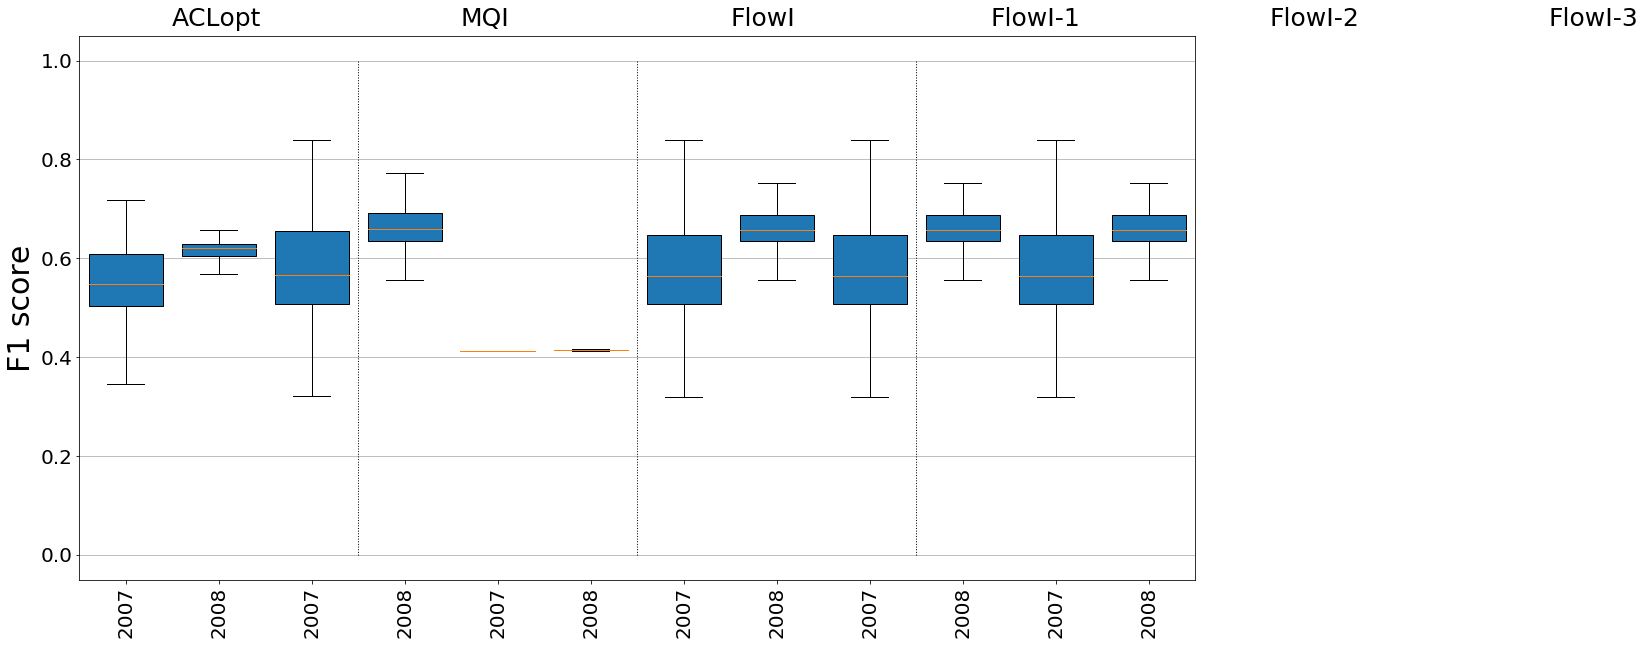

In [16]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_pre_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Brandeis_f1_Optimal.png')

plt.show()

## Generate scatter plot for precision

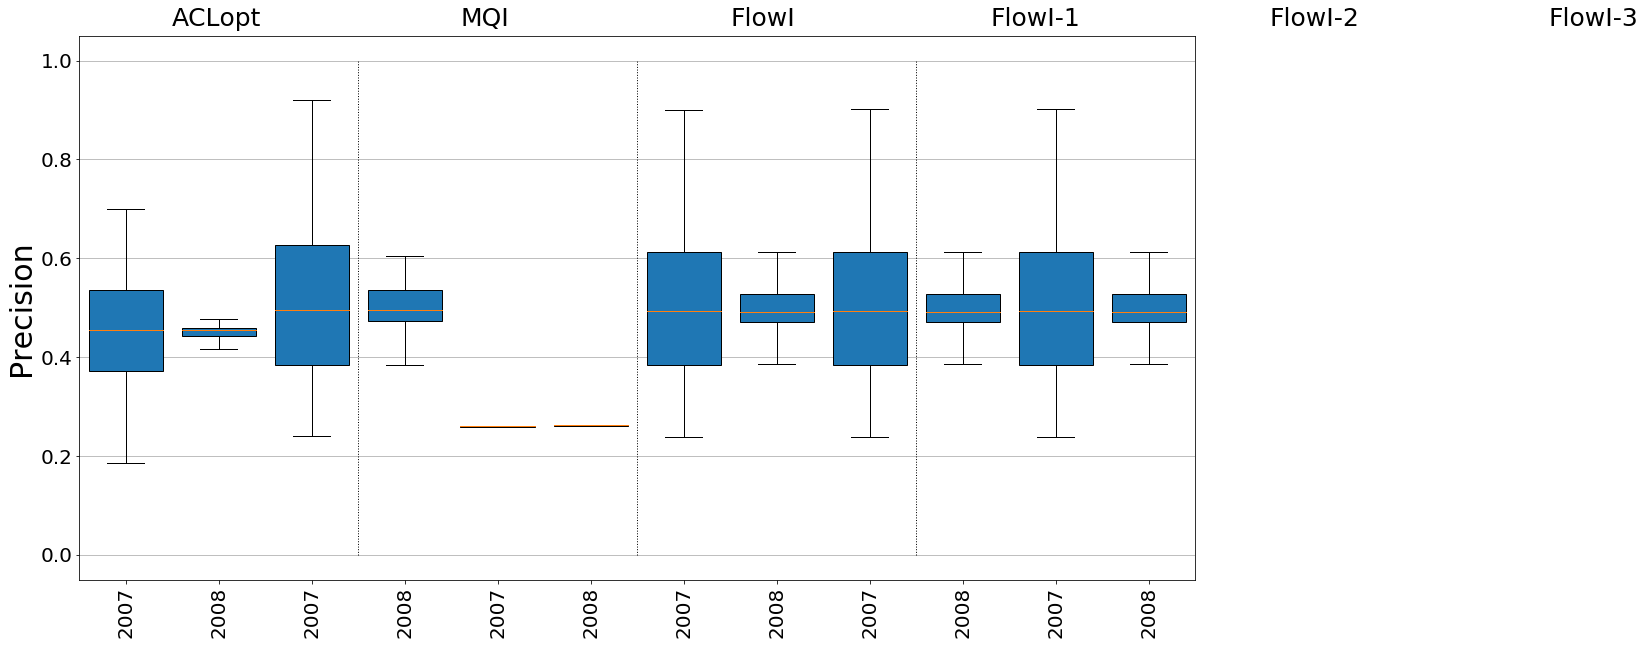

In [17]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Brandeis_precision_Optimal.png')

plt.show()

## Generate scatter plot for recall

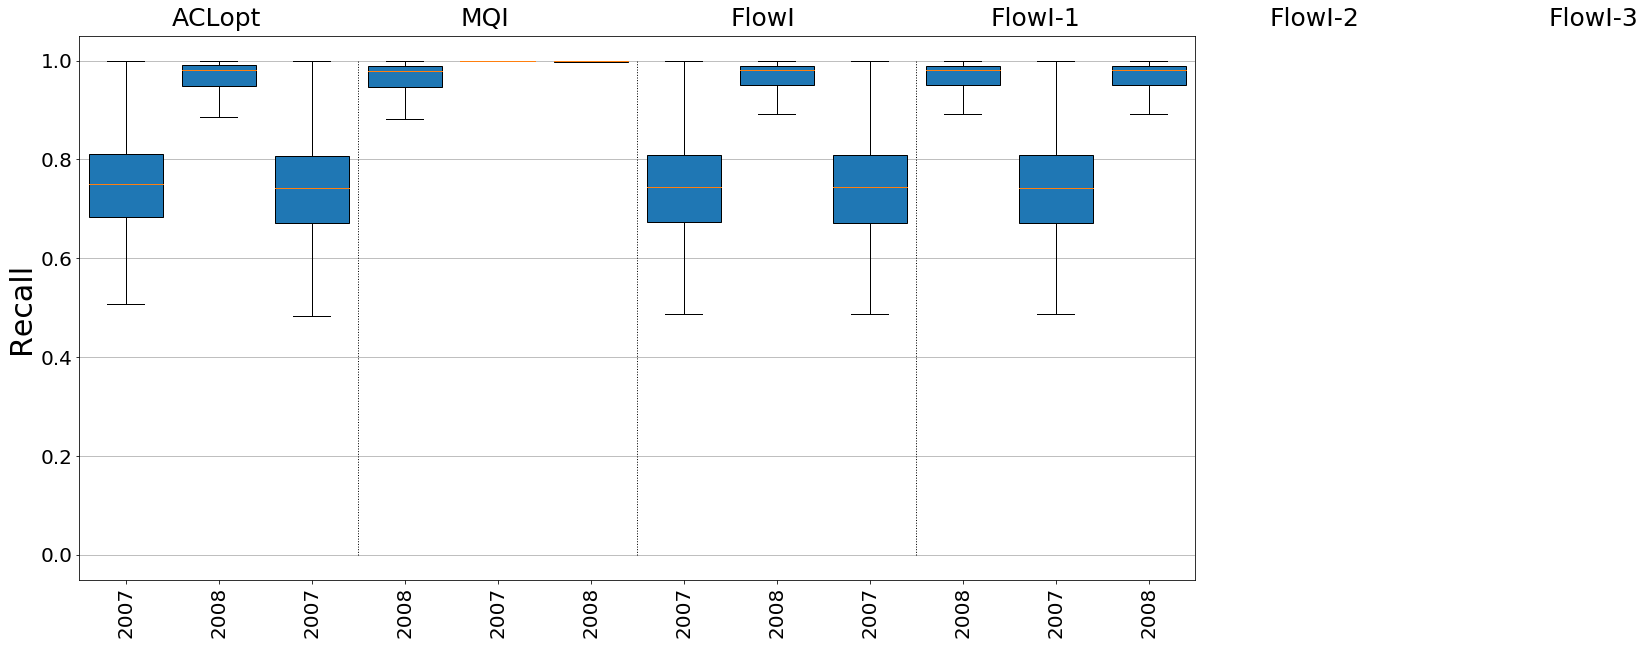

In [18]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_pre_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Brandeis_recall_Optimal.png')

plt.show()

## Generate precision/recall and F1 scores

In [19]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
        temp_rec.append(recall_best_pre_acl[i,j])
        temp_f1.append(f1score_best_pre_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 2007 Precision 0.4550109281582321 Recall 0.7497978532811187 F1 0.5482299646595881
Feature: 2008 Precision 0.4548786340697218 Recall 0.9809937849205851 F1 0.6216292734777404
Results for MQI
Feature: 2007 Precision 0.49623575277569065 Recall 0.7419418768728299 F1 0.5662251661581603
Feature: 2008 Precision 0.4955873934613917 Recall 0.9793144579069621 F1 0.6583594259103263
Results for FlowI
Feature: 2007 Precision 0.25989229013263887 Recall 1.0 F1 0.4125519181083821
Feature: 2008 Precision 0.2618603943249458 Recall 0.9988385962709524 F1 0.4149141263394824
Results for FlowI-1
Feature: 2007 Precision 0.49362642021544045 Recall 0.7436066145577347 F1 0.5641900686397563
Feature: 2008 Precision 0.4922800577921824 Recall 0.9804758616360097 F1 0.6563262552637543
Results for FlowI-2
Feature: 2007 Precision 0.49319637915931475 Recall 0.7434877047230986 F1 0.5642191141924242
Feature: 2008 Precision 0.4922800577921824 Recall 0.9804758616360097 F1 0.6563262552637543
Results 